<a href="https://colab.research.google.com/github/JoDeMiro/Micado-Research/blob/main/MiCADO1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

from sklearn import preprocessing

from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

In [302]:
#@title
from matplotlib import pyplot
from math import cos, sin, atan
from palettable.tableau import Tableau_10
from time import localtime, strftime
import numpy as np

class Neuron():
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def draw(self, neuron_radius, id=-1, name=None):
        circle = pyplot.Circle((self.x, self.y), radius=neuron_radius, fill=False)
        pyplot.gca().add_patch(circle)
        pyplot.gca().text(self.x, self.y-0.15, str(id), size=10, ha='center')
        if name is not None:
          pyplot.gca().text(self.x+0.05, self.y-0.5, str(name), size=20, ha='center', va='top', rotation='vertical')

class Layer():
    def __init__(self, network, number_of_neurons, number_of_neurons_in_widest_layer, input_names=None):
        self.vertical_distance_between_layers = 6
        self.horizontal_distance_between_neurons = 2
        self.neuron_radius = 0.5
        self.number_of_neurons_in_widest_layer = number_of_neurons_in_widest_layer
        self.previous_layer = self.__get_previous_layer(network)
        self.y = self.__calculate_layer_y_position()
        self.neurons = self.__intialise_neurons(number_of_neurons)
        self.input_names = input_names

    def __intialise_neurons(self, number_of_neurons):
        neurons = []
        x = self.__calculate_left_margin_so_layer_is_centered(number_of_neurons)
        for iteration in range(number_of_neurons):
            neuron = Neuron(x, self.y)
            neurons.append(neuron)
            x += self.horizontal_distance_between_neurons
        return neurons

    def __calculate_left_margin_so_layer_is_centered(self, number_of_neurons):
        return self.horizontal_distance_between_neurons * (self.number_of_neurons_in_widest_layer - number_of_neurons) / 2

    def __calculate_layer_y_position(self):
        if self.previous_layer:
            return self.previous_layer.y + self.vertical_distance_between_layers
        else:
            return 0

    def __get_previous_layer(self, network):
        if len(network.layers) > 0:
            return network.layers[-1]
        else:
            return None

    def __line_between_two_neurons(self, neuron1, neuron2, weight=0.4, textoverlaphandler=None):
        angle = atan((neuron2.x - neuron1.x) / float(neuron2.y - neuron1.y))
        x_adjustment = self.neuron_radius * sin(angle)
        y_adjustment = self.neuron_radius * cos(angle)

        # assign colors to lines depending on the sign of the weight
        color=Tableau_10.mpl_colors[0]
        if weight > 0: color=Tableau_10.mpl_colors[1]

        # assign different linewidths to lines depending on the size of the weight
        abs_weight = abs(weight)        
        if abs_weight > 0.5: 
            linewidth = 5*abs_weight
        elif abs_weight > 0.8: 
            linewidth =  50*abs_weight
        else:
            linewidth = abs_weight

        # draw the weights and adjust the labels of weights to avoid overlapping
        if abs_weight > 0.5: 
            # while loop to determine the optimal locaton for text lables to avoid overlapping
            index_step = 2
            num_segments = 10   
            txt_x_pos = neuron1.x - x_adjustment+index_step*(neuron2.x-neuron1.x+2*x_adjustment)/num_segments
            txt_y_pos = neuron1.y - y_adjustment+index_step*(neuron2.y-neuron1.y+2*y_adjustment)/num_segments
            while ((not textoverlaphandler.getspace([txt_x_pos-0.5, txt_y_pos-0.5, txt_x_pos+0.5, txt_y_pos+0.5])) and index_step < num_segments):
                index_step = index_step + 1
                txt_x_pos = neuron1.x - x_adjustment+index_step*(neuron2.x-neuron1.x+2*x_adjustment)/num_segments
                txt_y_pos = neuron1.y - y_adjustment+index_step*(neuron2.y-neuron1.y+2*y_adjustment)/num_segments

            # print("Label positions: ", "{:.2f}".format(txt_x_pos), "{:.2f}".format(txt_y_pos), "{:3.2f}".format(weight))
            a=pyplot.gca().text(txt_x_pos, txt_y_pos, "{:3.2f}".format(weight), size=12, ha='center')
            a.set_bbox(dict(facecolor='white', alpha=0))
            # print(a.get_bbox_patch().get_height())

        line = pyplot.Line2D((neuron1.x - x_adjustment, neuron2.x + x_adjustment), (neuron1.y - y_adjustment, neuron2.y + y_adjustment), linewidth=linewidth, color=color)
        pyplot.gca().add_line(line)

    def draw(self, layerType=0, weights=None, textoverlaphandler=None):
        j=0 # index for neurons in this layer
        z=0 # counter for names
        for neuron in self.neurons:            
            i=0 # index for neurons in previous layer
            if(layerType==0):
              name = self.input_names[z]
              neuron.draw( self.neuron_radius, id=j+1, name=name)
            else:
              neuron.draw( self.neuron_radius, id=j+1)
            if self.previous_layer:
                for previous_layer_neuron in self.previous_layer.neurons:
                    self.__line_between_two_neurons(neuron, previous_layer_neuron, weights[i,j], textoverlaphandler)
                    i=i+1
            j=j+1
            z=z+1
        
        # write Text
        x_text = self.number_of_neurons_in_widest_layer * self.horizontal_distance_between_neurons
        if layerType == 0:
            pyplot.text(x_text, self.y, 'Input Layer', fontsize = 12)
        elif layerType == -1:
            pyplot.text(x_text, self.y, 'Output Layer', fontsize = 12)
        else:
            pyplot.text(x_text, self.y, 'Hidden Layer '+str(layerType), fontsize = 12)

# A class to handle Text Overlapping
# The idea is to first create a grid space, if a grid is already occupied, then
# the grid is not available for text labels.
class TextOverlappingHandler():
    # initialize the class with the width and height of the plot area
    def __init__(self, width, height, grid_size=0.2):
        self.grid_size = grid_size
        self.cells = np.ones((int(np.ceil(width / grid_size)), int(np.ceil(height / grid_size))), dtype=bool)

    # input test_coordinates(bottom left and top right), 
    # getspace will tell you whether a text label can be put in the test coordinates
    def getspace(self, test_coordinates):
        x_left_pos = int(np.floor(test_coordinates[0]/self.grid_size))
        y_botttom_pos = int(np.floor(test_coordinates[1]/self.grid_size))
        x_right_pos = int(np.floor(test_coordinates[2]/self.grid_size))
        y_top_pos = int(np.floor(test_coordinates[3]/self.grid_size))
        if self.cells[x_left_pos, y_botttom_pos] and self.cells[x_left_pos, y_top_pos] \
        and self.cells[x_right_pos, y_top_pos] and self.cells[x_right_pos, y_botttom_pos]:
            for i in range(x_left_pos, x_right_pos):
                for j in range(y_botttom_pos, y_top_pos):
                    self.cells[i, j] = False

            return True
        else:
            return False

class NeuralNetwork():
    def __init__(self, number_of_neurons_in_widest_layer, input_names=None):
        self.number_of_neurons_in_widest_layer = number_of_neurons_in_widest_layer
        self.layers = []
        self.layertype = 0
        self.input_names = []
        if (input_names == None):
            self.input_names = []
        else:
            self.input_names = input_names

    def add_layer(self, number_of_neurons ):
        layer = Layer(self, number_of_neurons, self.number_of_neurons_in_widest_layer, self.input_names)
        self.layers.append(layer)

    def draw(self, weights_list=None, input_names=None):
        # vertical_distance_between_layers and horizontal_distance_between_neurons are the same with the variables of the same name in layer class
        vertical_distance_between_layers = 6
        horizontal_distance_between_neurons = 2
        overlaphandler = TextOverlappingHandler(\
            self.number_of_neurons_in_widest_layer*horizontal_distance_between_neurons,\
            len(self.layers)*vertical_distance_between_layers, grid_size=0.2 )

        if( len(self.input_names) <= 10 ):
          pyplot.figure(figsize=(12, 9))
        elif( len(self.input_names) > 10 ):
          pyplot.figure(figsize=(24, 10))
        else:
          pyplot.figure(figsize=(12,9))
        for i in range( len(self.layers) ):
            layer = self.layers[i]                                
            if i == 0:
                layer.draw( layerType=0 )
            elif i == len(self.layers)-1:
                layer.draw( layerType=-1, weights=weights_list[i-1], textoverlaphandler=overlaphandler)
            else:
                layer.draw( layerType=i, weights=weights_list[i-1], textoverlaphandler=overlaphandler)

        pyplot.axis('scaled')
        pyplot.axis('off')
        pyplot.title( 'Neural Network architecture', fontsize=15 )
        figureName='ANN_'+strftime("%Y%m%d_%H%M%S", localtime())+'.png'
        pyplot.savefig(figureName, dpi=300, bbox_inches="tight")
        pyplot.show()

class DrawNN():
    # para: neural_network is an array of the number of neurons 
    # from input layer to output layer, e.g., a neural network of 5 nerons in the input layer, 
    # 10 neurons in the hidden layer 1 and 1 neuron in the output layer is [5, 10, 1]
    # para: weights_list (optional) is the output weights list of a neural network which can be obtained via classifier.coefs_
    def __init__( self, neural_network, weights_list=None, input_names=None ):
        # self.input_names = input_names
        self.neural_network = neural_network
        self.weights_list = weights_list
        # if input_names exists
        if input_names is None:
          self.input_names = []
        else:
          self.input_names = input_names
        # if weights_list is none, then create a uniform list to fill the weights_list
        if weights_list is None:
            weights_list=[]
            for first, second in zip(neural_network, neural_network[1:]):
                tempArr = np.ones((first, second))*0.4
                weights_list.append(tempArr)
            self.weights_list = weights_list
        
    def draw( self ):
        widest_layer = max( self.neural_network )
        network = NeuralNetwork( widest_layer, self.input_names)
        for l in self.neural_network:
            network.add_layer(l)
        network.draw(self.weights_list)

In [503]:
#@title
def timeline_plot(real, estimated):
  plt.figure(figsize=(20, 6))
  plt.plot(real, label = 'Real')
  plt.plot(estimated, label = 'Estimated')
  plt.title('Estimated vs Real values', fontsize=18)
  plt.ylabel('Average Latency - Normalized', fontsize=18)
  plt.xlabel('N\'th observation, time', fontsize=18)
  plt.legend(fontsize=14, frameon=False)
  plt.show()

def train_test_real_predicted_scatter(y_train, y_test, y_pred_train, y_pred_test):
  fig, (a1, a2) = plt.subplots(1, 2, figsize=(20, 7), sharey=True)
  a1.scatter(y_train, y_pred_train)
  a1.set_title('Training data', fontsize=18)
  a1.set_ylabel('Predicted', fontsize=18)
  a1.set_xlabel('Real value', fontsize=18)
  r2 = np.corrcoef(y_train.ravel(), y_pred_train.ravel())[0,1]
  a1.annotate('r2 = ' + str(round(r2, 3)), xy=(0.2, 0.8), xycoords='axes fraction', fontsize=18, ha='center', va='center')

  a2.scatter(y_test, y_pred_test)
  a2.set_title('Test data', fontsize=18)
  a2.set_ylabel('Predicted', fontsize=18)
  a2.set_xlabel('Real value', fontsize=18)
  r2 = np.corrcoef(y_test.ravel(), y_pred_test.ravel())[0,1]
  a2.annotate('r2 = ' + str(round(r2, 3)), xy=(0.2, 0.8), xycoords='axes fraction', fontsize=18, ha='center', va='center')
  plt.show()

def train_test_real_predicted_scatter_sns(y_train, y_test, y_pred_train, y_pred_test):
  fig, (a1, a2) = plt.subplots(1, 2, figsize=(20, 7), sharey=True)
  sns.regplot(ax=a1, x = y_train, y = y_pred_train)
  a1.set_title('Training data', fontsize=18)
  a1.set_ylabel('Predicted', fontsize=18)
  a1.set_xlabel('Real value', fontsize=18)
  r2 = np.corrcoef(y_train.ravel(), y_pred_train.ravel())[0,1]
  a1.annotate('r2 = ' + str(round(r2, 3)), xy=(0.2, 0.8), xycoords='axes fraction', fontsize=18, ha='center', va='center')

  sns.regplot(ax=a2, x = y_test, y = y_pred_test)
  a2.set_title('Test data', fontsize=18)
  a2.set_ylabel('Predicted', fontsize=18)
  a2.set_xlabel('Real value', fontsize=18)
  r2 = np.corrcoef(y_test.ravel(), y_pred_test.ravel())[0,1]
  a2.annotate('r2 = ' + str(round(r2, 3)), xy=(0.2, 0.8), xycoords='axes fraction', fontsize=18, ha='center', va='center')
  plt.show()

def cummulative_plots(errors, cummulative_errors, y_real, y_predicted):
  plt.figure(figsize=(20,4))
  plt.plot(errors, label='Error per estimation')
  plt.ylabel('Error', fontsize=18)
  plt.legend(fontsize=14, frameon=False)
  plt.show()

  plt.figure(figsize=(20,4))
  plt.plot(cummulative_errors, label='Cummulative error')
  plt.ylabel('Cumulative error', fontsize=18)
  plt.legend(fontsize=14, frameon=False)
  plt.show()

  plt.figure(figsize=(20,4))
  plt.plot(y_predicted, label='predicted')
  plt.plot(y_real, label='real')
  plt.ylabel('Average Latency', fontsize=18)
  plt.xlabel('N\'th observation, time', fontsize=18)
  plt.legend(fontsize=14, frameon=False)
  plt.show()

def cummaulative_real_predicted_scatter(y_real, y_predicted):
  plt.figure(figsize=(10, 7))
  plt.scatter(y_real, y_predicted)
  plt.title('Estimated vas Real data', fontsize=18)
  plt.ylabel('Predicted', fontsize=18)
  plt.xlabel('Real value', fontsize=18)
  r2 = np.corrcoef(y_real, y_predicted)[0,1]
  plt.annotate('r2 = ' + str(round(r2, 3)), xy=(0.8, 0.2), xycoords='axes fraction', fontsize=18, ha='center', va='center')
  plt.show()

def cummaulative_real_predicted_scatter_sns(y_real, y_predicted):
  plt.figure(figsize=(10, 7))
  sns.regplot(x = y_real, y = y_predicted)
  plt.title('Estimated vas Real data', fontsize=18)
  plt.ylabel('Predicted', fontsize=18)
  plt.xlabel('Real value', fontsize=18)
  r2 = np.corrcoef(y_real, y_predicted)[0,1]
  plt.annotate('r2 = ' + str(round(r2, 3)), xy=(0.8, 0.2), xycoords='axes fraction', fontsize=18, ha='center', va='center')
  plt.show()


In [3]:
!wget https://github.com/JoDeMiro/Data/raw/main/Micado/nn_training_data.csv

--2021-06-25 10:34:48--  https://github.com/JoDeMiro/Data/raw/main/Micado/nn_training_data.csv
Resolving github.com (github.com)... 13.114.40.48
Connecting to github.com (github.com)|13.114.40.48|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/JoDeMiro/Data/main/Micado/nn_training_data.csv [following]
--2021-06-25 10:34:49--  https://raw.githubusercontent.com/JoDeMiro/Data/main/Micado/nn_training_data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 156914 (153K) [text/plain]
Saving to: ‘nn_training_data.csv’

nn_training_data.cs 100%[===================>] 153.24K  --.-KB/s    in 0.03s   

2021-06-25 10:34:49 (5.52 MB/s) - ‘nn_training_data.csv’ saved [156914/156914]



In [4]:
df = pd.read_csv('nn_training_data.csv')

In [5]:
df.head()

timestamp     PktIn      KBIn  ...    PktOut  vm_number  AVG_LAT_05
0  1571923606  0.291658  0.029784  ...  0.241660          5      466.25
1  1571923621  0.300010  0.030584  ...  0.250011          5      457.25
2  1571923637  0.275005  0.029102  ...  0.291673          5      433.25
3  1571923652  0.275002  0.029330  ...  0.241668          5      410.25
4  1571923683  0.300004  0.030583  ...  0.250001          5      429.25

[5 rows x 12 columns]

In [6]:
# gyors testzek a változókra

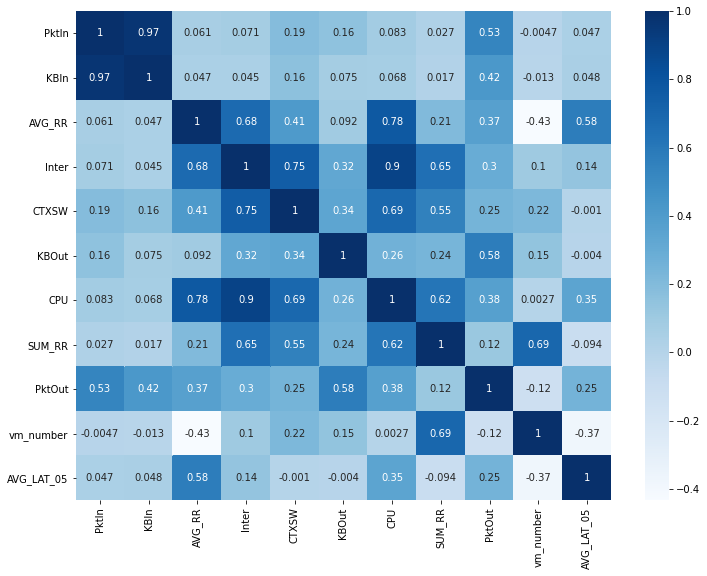

In [7]:
# korrelácó az egyes változók között
corr = df.iloc[: , 1:].corr()

plt.figure(figsize=(12,9))
sns.heatmap(corr, cmap="Blues", annot=True)
# plt.savefig('correlation_matrix.png')
plt.show()


In [8]:
# Keressük meg azokat az adatokat ahol változott a gépek száma

In [9]:
def createBeforeafterDF(df, lag, inputMetrics):
    beforeafterDF = df.copy()
    length = len(inputMetrics)
    # print(length)
    inputVariables = np.flip(beforeafterDF.columns[0:length].ravel(), axis=-1)
    # print('Input Variablels : ', inputVariables)

    index = length
    for i in inputVariables:
        new_column = beforeafterDF[i].shift(lag)
        new_column_name = (i + str(1)) # Todo: rename str(lag)
        beforeafterDF.insert(loc=index, column=new_column_name, value=new_column)

    beforeafterDF = beforeafterDF[lag:]

    return beforeafterDF

# Fontos
metrics = df.columns

# Before After adatok egy sorban
ba = createBeforeafterDF(df, 1, metrics)

# Csak azok az adatok ahol tényleges eltérés volt a gépek száma között
def createScalingDF(theBeforeAfterDF):
  new_beforeafterDF = theBeforeAfterDF.copy()
  scalingDF = new_beforeafterDF[new_beforeafterDF.vm_number != new_beforeafterDF.vm_number1]
  return scalingDF

fd = createScalingDF(ba)

rossz = fd.copy()

# Ki kell szűrni azokat az eseteket, ahol egynél több gépet adott hozzá, vagy vett el
fd['difference'] = fd['vm_number']-fd['vm_number1']
fd['abs_difference'] = abs(fd['difference'])
fd = fd[fd['abs_difference'] < 2]

print(fd.shape)

(46, 26)


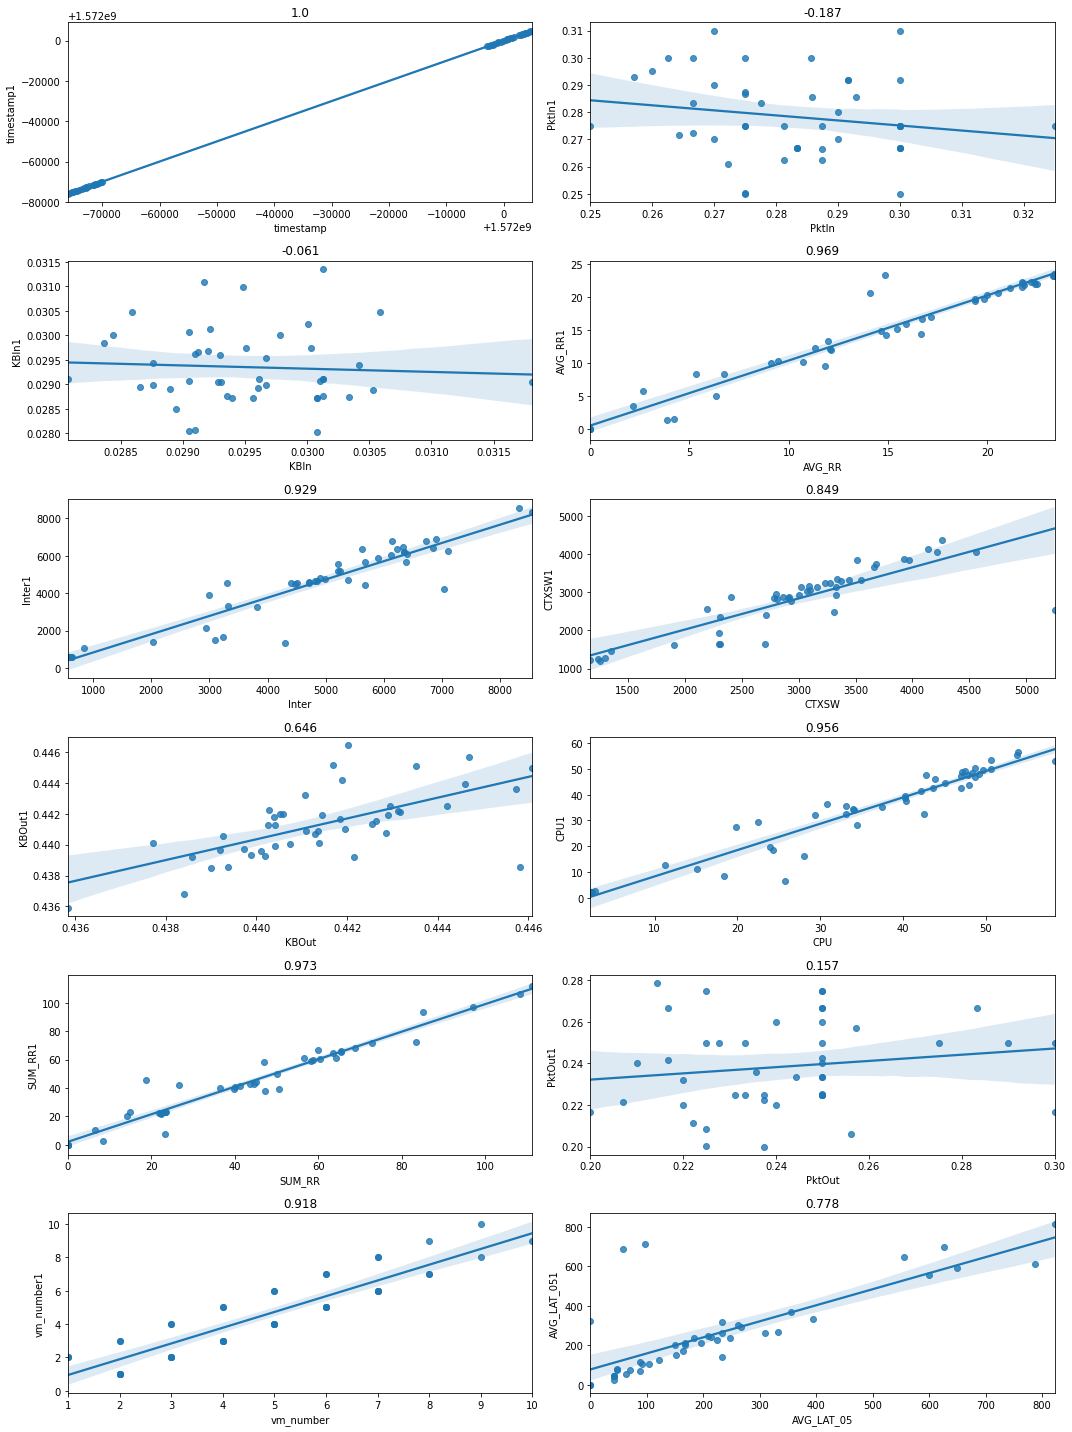

In [47]:
# Most nézzük meg, hogy milyen korreláció van az egyes before after változók között

fig, axes = plt.subplots(6, 2, figsize=(15, 20), sharey=False)
for j, i in enumerate(df.columns):
  corr = str(round(fd[i].corr(fd[i+'1']), 3))

  r = int(j/2)
  c = 1 if (j % 2 == 1) else 0
  sns.regplot(ax=axes[r, c], x = fd[i], y = fd[i+'1']).set_title(corr)

plt.tight_layout()
plt.show()


r2  =  0.9130603783494109
r2w =  0.913060378349411


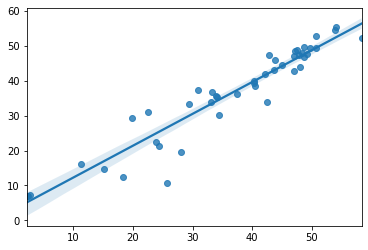

In [28]:
# Regresszió

y = fd['CPU'].values          # Current
x = fd['CPU1'].values         # Lag
x = x.reshape(-1,1)
x1 = fd[['CPU1', 'CTXSW1']].values
# még a vm számmal kell kipróbálni, kíváncsi vagyok az javít vagy ront-e a helyzeten


regression = LinearRegression()

regression.fit(x,y)

y_pred = regression.predict(x)

r2  = r2_score(y, y_pred)
r2w = r2_score(y, y_pred, multioutput='variance_weighted')

print('r2  = ', r2)
print('r2w = ', r2w)

sns.regplot(y, y_pred)
plt.show()

In [29]:
df.columns

Index(['timestamp', 'PktIn', 'KBIn', 'AVG_RR', 'Inter', 'CTXSW', 'KBOut',
       'CPU', 'SUM_RR', 'PktOut', 'vm_number', 'AVG_LAT_05'],
      dtype='object')

r2_old  =  0.913680266453026 	 r2w_old =  0.9136802664530261
r2_new  =  0.9286288096138708 	 r2w_new =  0.9286288096138707


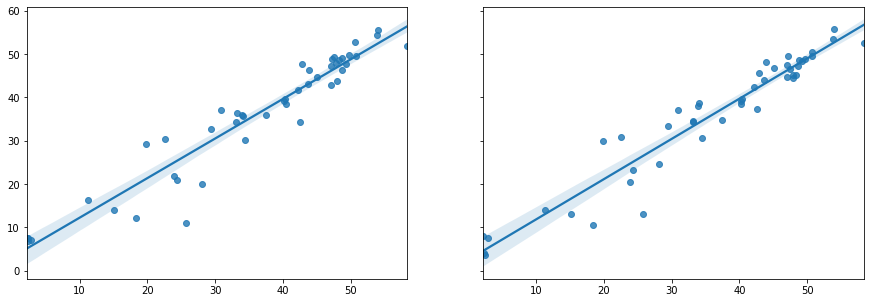

In [31]:
# Regresszió

y     = fd['CPU'].values          # Current
x_old = fd[['CPU1', 'vm_number1']].values
x_new = fd[['CPU1', 'PktIn1', 'KBIn1', 'AVG_RR1', 'Inter1', 'CTXSW1', 'KBOut1', 'KBOut1', 'SUM_RR1', 'PktOut1', 'vm_number1', 'AVG_LAT_051']].values


regression = LinearRegression()

# fit old
regression.fit(x_old, y)
y_pred_old = regression.predict(x_old)
r2_old  = r2_score(y, y_pred_old)
r2w_old = r2_score(y, y_pred_old, multioutput='variance_weighted')

# fit new
regression.fit(x_new, y)
y_pred_new = regression.predict(x_new)
r2_new  = r2_score(y, y_pred_new)
r2w_new = r2_score(y, y_pred_new, multioutput='variance_weighted')


print('r2_old  = ', r2_old, '\t', 'r2w_old = ', r2w_old)
print('r2_new  = ', r2_new, '\t', 'r2w_new = ', r2w_new)


fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
sns.regplot(ax=axes[0], x = y, y = y_pred_old)
sns.regplot(ax=axes[1], x = y, y = y_pred_new)
plt.show()


timestamp
r2_old  =  0.024267027237014904 	 r2w_old =  0.024267027237014904
r2_lat  =  0.43141851534249676 	 r2w_lat =  0.43141851534249676
r2_new  =  0.5142334051798534 	 r2w_new =  0.5142334051798534


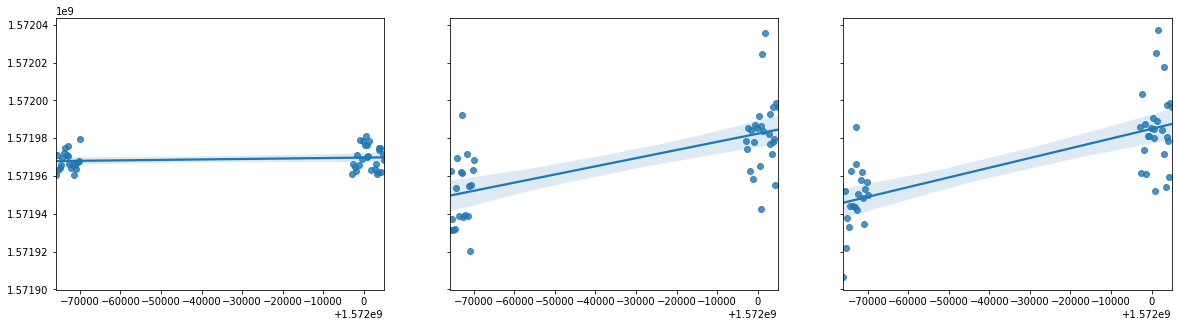

PktIn
r2_old  =  0.07387523363062087 	 r2w_old =  0.07387523363062087
r2_lat  =  0.3409924781855713 	 r2w_lat =  0.3409924781855713
r2_new  =  0.39088543590769675 	 r2w_new =  0.3908854359076968


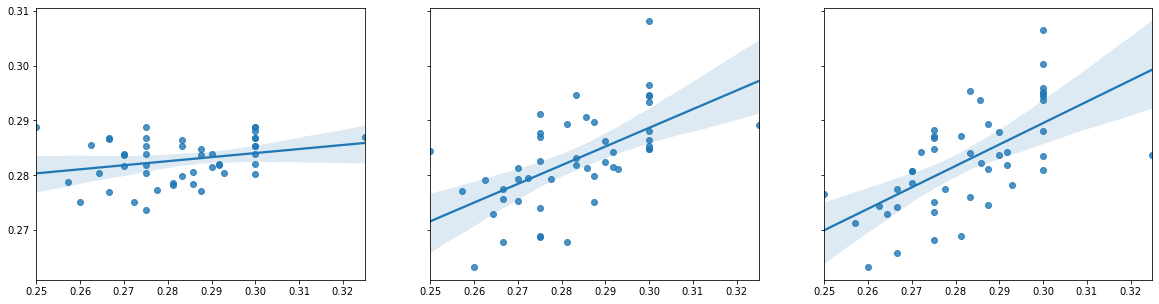

KBIn
r2_old  =  0.08732485075187513 	 r2w_old =  0.08732485075187511
r2_lat  =  0.2875622213739255 	 r2w_lat =  0.2875622213739255
r2_new  =  0.31243252924543174 	 r2w_new =  0.31243252924543174


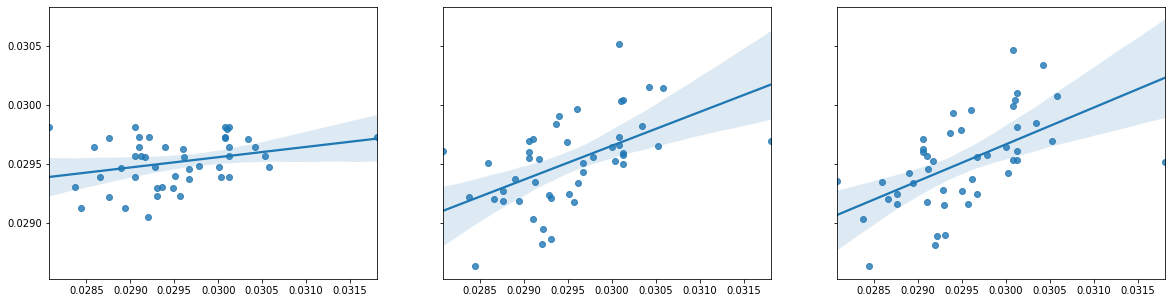

AVG_RR
r2_old  =  0.8616446233528713 	 r2w_old =  0.8616446233528714
r2_lat  =  0.95944315986659 	 r2w_lat =  0.95944315986659
r2_new  =  0.9604190216574839 	 r2w_new =  0.9604190216574839


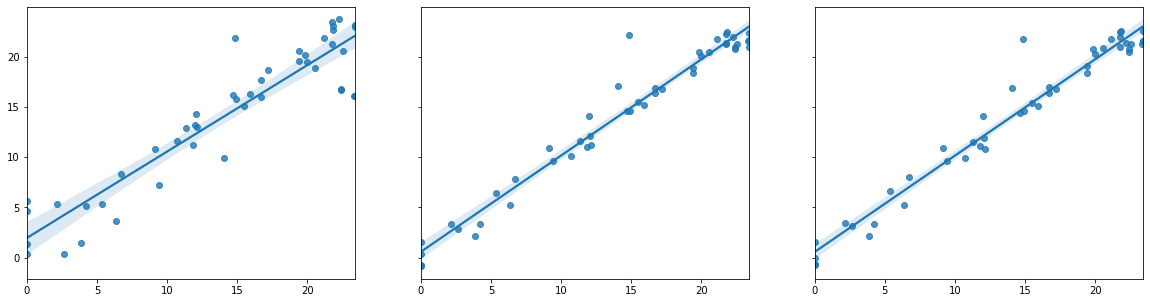

Inter
r2_old  =  0.7118537045696511 	 r2w_old =  0.7118537045696511
r2_lat  =  0.8914287558227773 	 r2w_lat =  0.8914287558227773
r2_new  =  0.8936558322785919 	 r2w_new =  0.8936558322785919


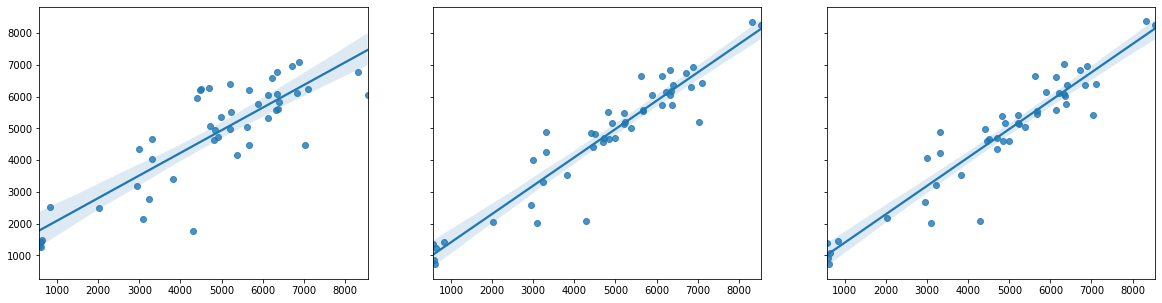

CTXSW
r2_old  =  0.5970407379531768 	 r2w_old =  0.5970407379531768
r2_lat  =  0.7952334067297732 	 r2w_lat =  0.7952334067297732
r2_new  =  0.798488139002192 	 r2w_new =  0.798488139002192


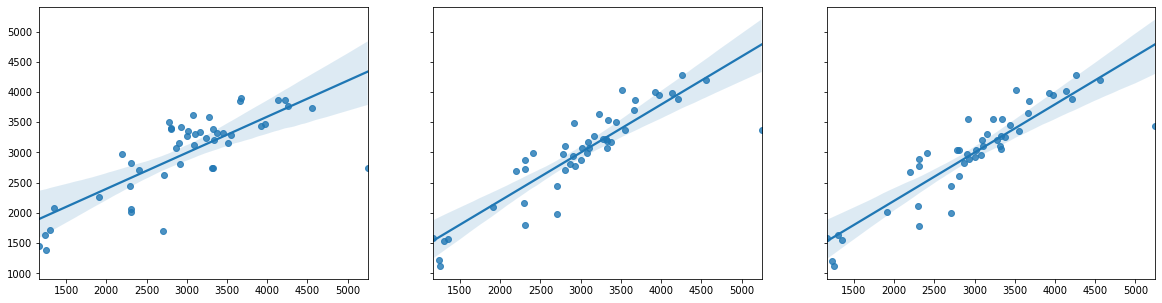

KBOut
r2_old  =  0.14947536733439382 	 r2w_old =  0.14947536733439382
r2_lat  =  0.6710786435992231 	 r2w_lat =  0.6710786435992231
r2_new  =  0.7014191892935107 	 r2w_new =  0.7014191892935105


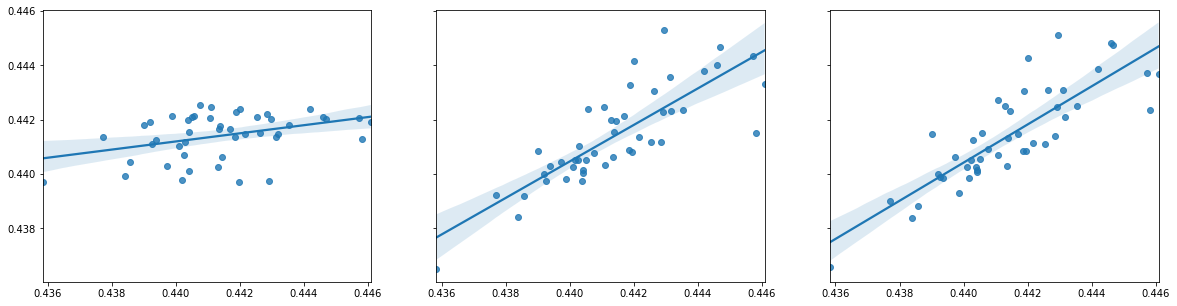

CPU
r2_old  =  0.913680266453026 	 r2w_old =  0.9136802664530261
r2_lat  =  0.9284076542167097 	 r2w_lat =  0.9284076542167097
r2_new  =  0.9286288096138708 	 r2w_new =  0.9286288096138707


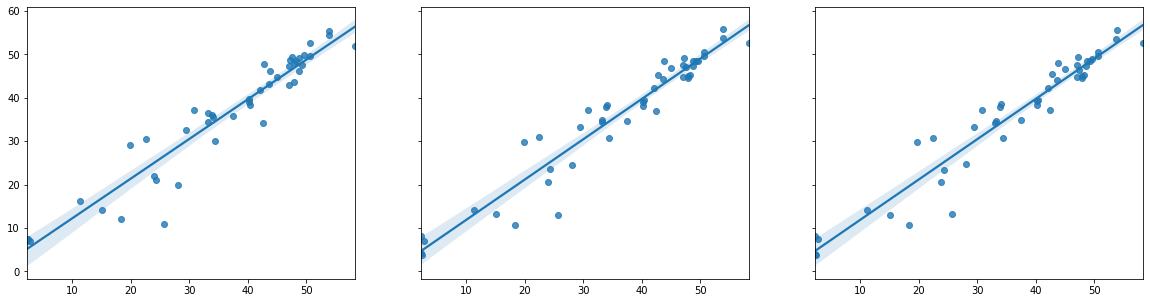

SUM_RR
r2_old  =  0.8301538132323607 	 r2w_old =  0.8301538132323607
r2_lat  =  0.9708361227963863 	 r2w_lat =  0.9708361227963862
r2_new  =  0.9715995248057119 	 r2w_new =  0.9715995248057119


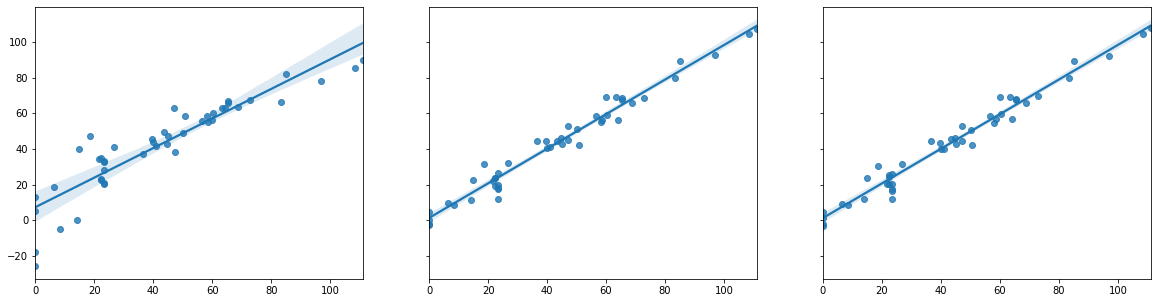

PktOut
r2_old  =  0.26402705309547725 	 r2w_old =  0.26402705309547725
r2_lat  =  0.4762798274205655 	 r2w_lat =  0.4762798274205655
r2_new  =  0.5163974366150159 	 r2w_new =  0.5163974366150159


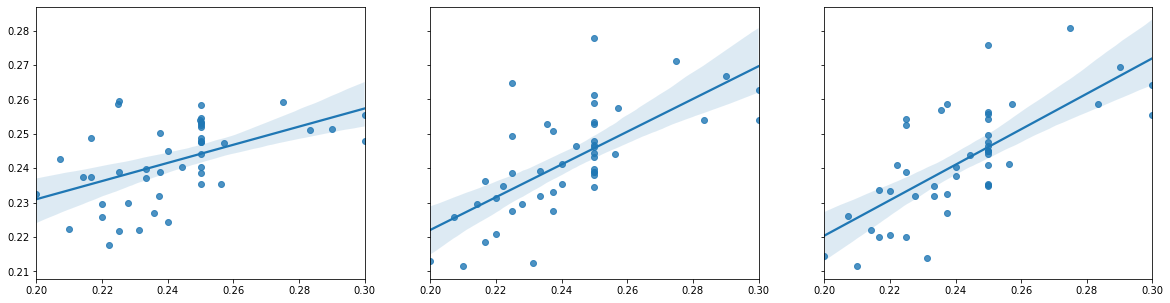

vm_number
r2_old  =  0.8426446101555061 	 r2w_old =  0.8426446101555061
r2_lat  =  0.9091540718376918 	 r2w_lat =  0.9091540718376918
r2_new  =  0.9111777301027364 	 r2w_new =  0.9111777301027364


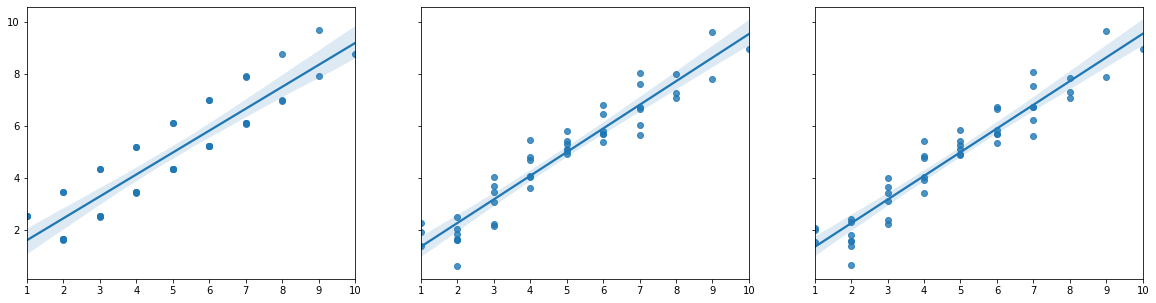

AVG_LAT_05
r2_old  =  0.3639153975458014 	 r2w_old =  0.3639153975458014
r2_lat  =  0.49654805317815687 	 r2w_lat =  0.49654805317815687
r2_new  =  0.6780142357193082 	 r2w_new =  0.6780142357193082


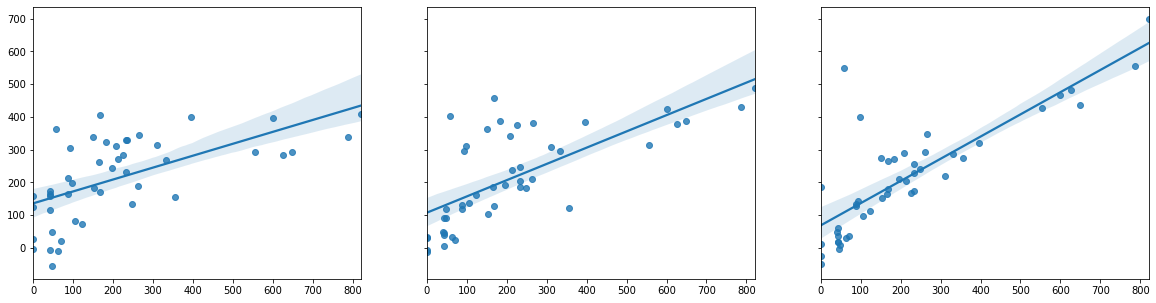

In [32]:
# Regresszió
for i in df.columns:
  y     = fd[i].values               # Current
  x_old = fd[['CPU1', 'vm_number1']].values
  x_new = fd[['CPU1', 'PktIn1', 'KBIn1', 'AVG_RR1', 'Inter1', 'CTXSW1', 'KBOut1', 'KBOut1', 'SUM_RR1', 'PktOut1', 'vm_number1', 'AVG_LAT_051']].values
  x_lat = fd[['CPU1', 'PktIn1', 'KBIn1', 'AVG_RR1', 'Inter1', 'CTXSW1', 'KBOut1', 'KBOut1', 'SUM_RR1', 'PktOut1', 'vm_number1']].values


  regression = LinearRegression()

  # fit old
  regression.fit(x_old, y)
  y_pred_old = regression.predict(x_old)
  r2_old  = r2_score(y, y_pred_old)
  r2w_old = r2_score(y, y_pred_old, multioutput='variance_weighted')

  # fit new
  regression.fit(x_new, y)
  y_pred_new = regression.predict(x_new)
  r2_new  = r2_score(y, y_pred_new)
  r2w_new = r2_score(y, y_pred_new, multioutput='variance_weighted')

  # fit without latency
  regression.fit(x_lat, y)
  y_pred_lat = regression.predict(x_lat)
  r2_lat  = r2_score(y, y_pred_lat)
  r2w_lat = r2_score(y, y_pred_lat, multioutput='variance_weighted')



  print(i)
  print('r2_old  = ', r2_old, '\t', 'r2w_old = ', r2w_old)
  print('r2_lat  = ', r2_lat, '\t', 'r2w_lat = ', r2w_lat)
  print('r2_new  = ', r2_new, '\t', 'r2w_new = ', r2w_new)


  fig, axes = plt.subplots(1, 3, figsize=(20, 5), sharey=True)
  sns.regplot(ax=axes[0], x = y, y = y_pred_old)
  sns.regplot(ax=axes[1], x = y, y = y_pred_lat)
  sns.regplot(ax=axes[2], x = y, y = y_pred_new)
  # plt.savefig('before_after.png')
  plt.show()
  


In [ ]:
# NN, a request rate nélkül

In [426]:
df.columns

Index(['timestamp', 'PktIn', 'KBIn', 'AVG_RR', 'Inter', 'CTXSW', 'KBOut',
       'CPU', 'SUM_RR', 'PktOut', 'vm_number', 'AVG_LAT_05'],
      dtype='object')

In [427]:
columns = ['PktIn', 'KBIn', 'Inter', 'CTXSW', 'KBOut', 'CPU', 'PktOut']

X = df[columns].values
y = df['AVG_LAT_05']

min_max_scaler = preprocessing.MinMaxScaler()
X_scaled = min_max_scaler.fit_transform(X)
y_scaled = min_max_scaler.fit_transform(y.values.reshape(-1, 1))

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.33, random_state=1, shuffle=False)

activation_function = 'relu'        # tanh, relu, logistic

mlp = MLPRegressor(hidden_layer_sizes=(4,),
                           max_iter=500,
                           activation=activation_function,
                           solver="lbfgs",
                           learning_rate="constant",
                           learning_rate_init=0.01,
                           alpha=0.01,
                           verbose=False,
                           momentum=0.9,
                           early_stopping=False,
                           tol=0.00000001,
                           shuffle=False,
                           # n_iter_no_change=20, \
                           random_state=1234)


mlp.fit(X_train, y_train)

y_pred_train = mlp.predict(X_train)
y_pred_test  = mlp.predict(X_test)

r2_train = np.corrcoef(y_train.ravel(), y_pred_train)[0,1]
r2_test  = np.corrcoef(y_test.ravel(), y_pred_test)[0,1]

print('r2 train = ', r2_train)
print('r2 test  = ', r2_test)

r2 train =  0.7564036873537339
r2 test  =  0.5828787355406381


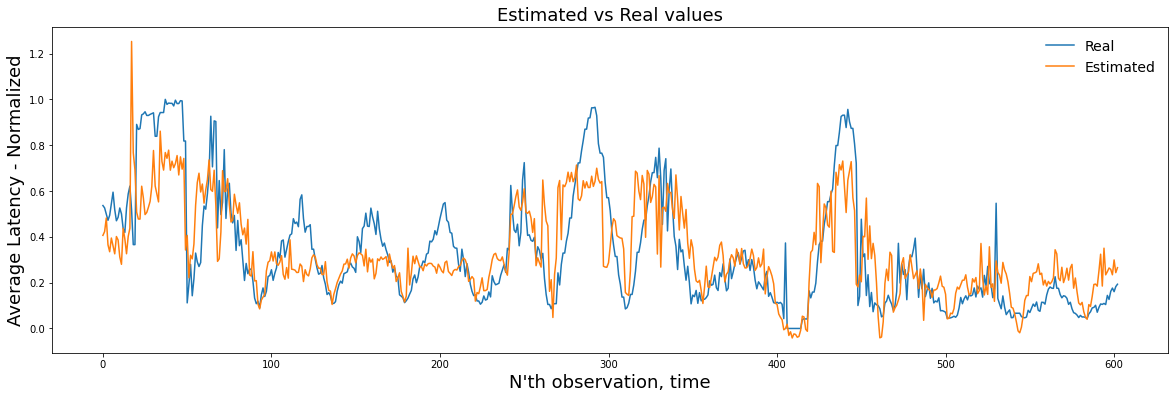

In [429]:
timeline_plot(y_train, y_pred_train)

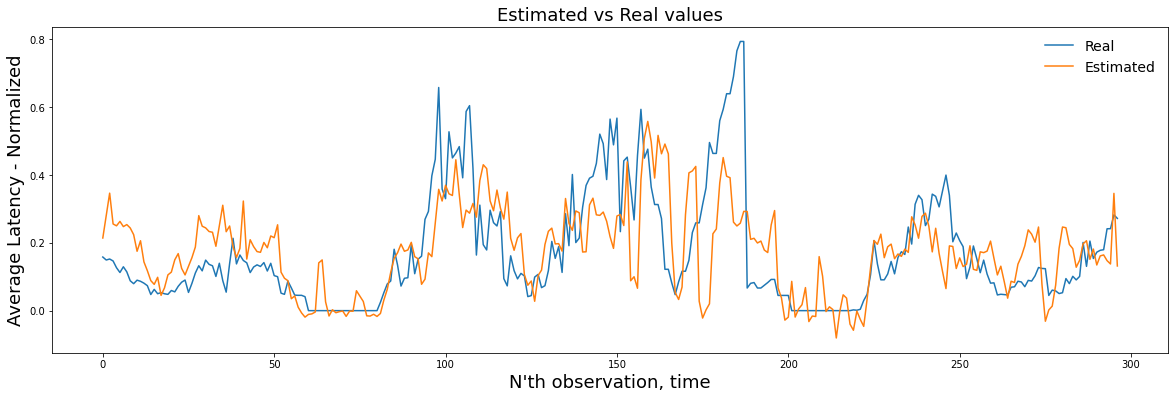

In [430]:
timeline_plot(y_test, y_pred_test)

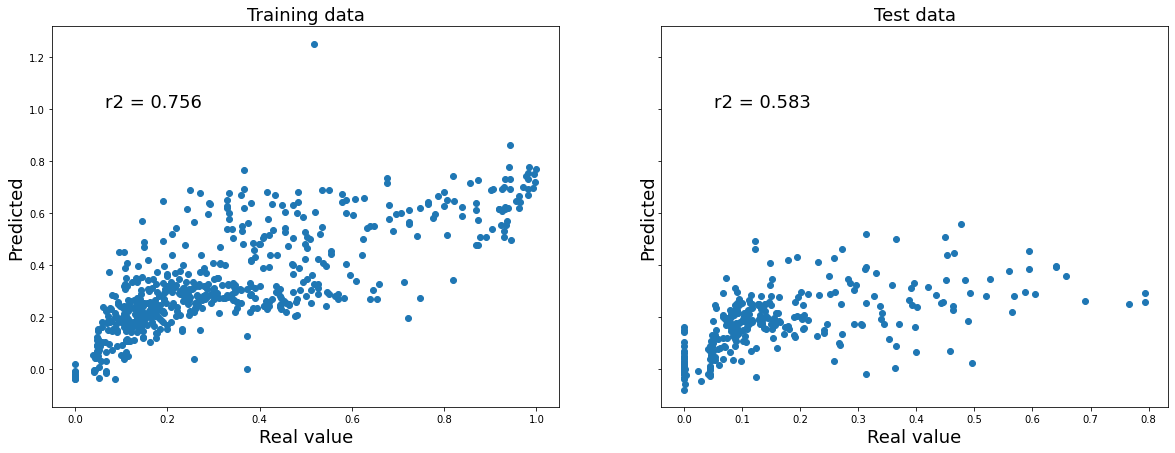

In [433]:
train_test_real_predicted_scatter(y_train, y_test, y_pred_train, y_pred_test)

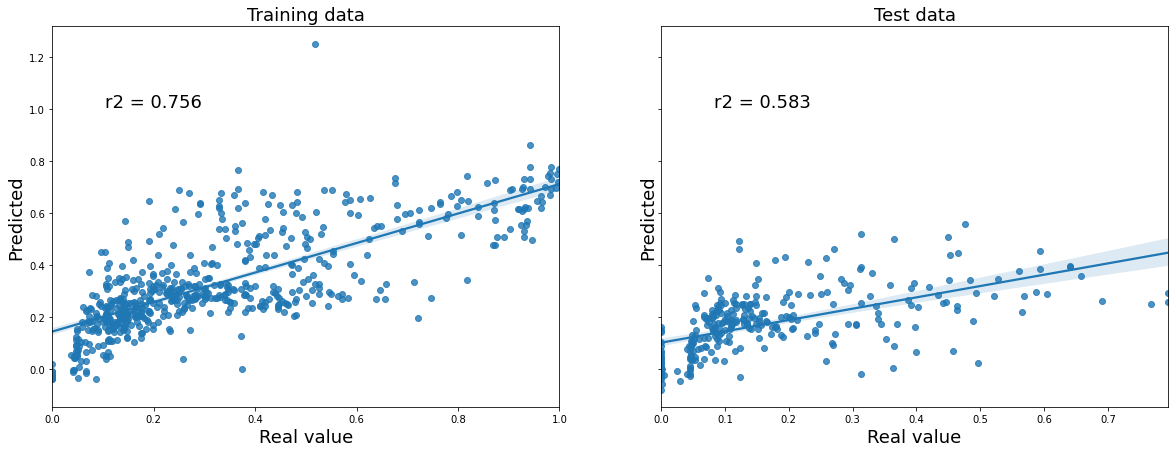

In [434]:
train_test_real_predicted_scatter_sns(y_train, y_test, y_pred_train, y_pred_test)

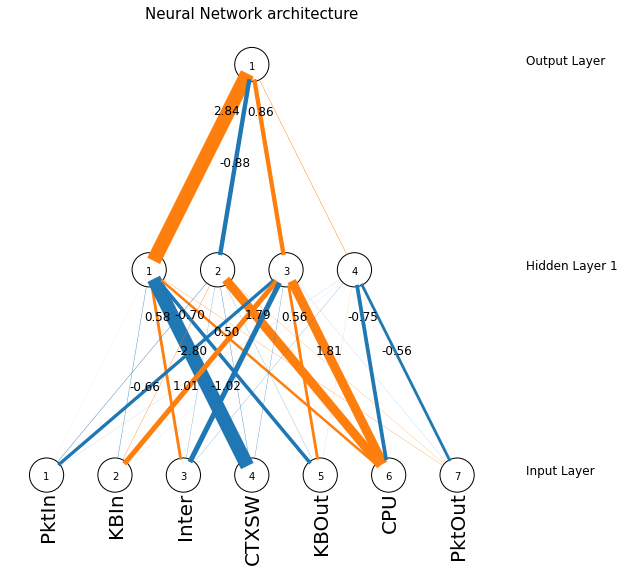

In [435]:
# Define the structure of the network
network_structure = np.hstack(([len(columns)], np.asarray(mlp.hidden_layer_sizes), [1]))

# Draw the Neural Network with weights
network=DrawNN(network_structure, mlp.coefs_, columns)
# network=DrawNN([3,4,1])
network.draw()

In [ ]:
# NN request rate nélkül laggal

In [436]:
ba.columns

Index(['timestamp', 'PktIn', 'KBIn', 'AVG_RR', 'Inter', 'CTXSW', 'KBOut',
       'CPU', 'SUM_RR', 'PktOut', 'vm_number', 'AVG_LAT_05', 'timestamp1',
       'PktIn1', 'KBIn1', 'AVG_RR1', 'Inter1', 'CTXSW1', 'KBOut1', 'CPU1',
       'SUM_RR1', 'PktOut1', 'vm_number1', 'AVG_LAT_051'],
      dtype='object')

In [437]:
columns = ['PktIn', 'KBIn', 'Inter', 'CTXSW', 'KBOut', 'CPU', 'PktOut',
           'PktIn1', 'KBIn1', 'Inter1', 'CTXSW1', 'KBOut1', 'CPU1', 'PktOut1']

X = ba[columns].values
y = ba['AVG_LAT_05']

min_max_scaler = preprocessing.MinMaxScaler()
X_scaled = min_max_scaler.fit_transform(X)
y_scaled = min_max_scaler.fit_transform(y.values.reshape(-1, 1))

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.33, random_state=1, shuffle=False)

activation_function = 'relu'        # tanh, relu, logistic

mlp = MLPRegressor(hidden_layer_sizes=4,
                           max_iter=500,
                           activation=activation_function,
                           solver="lbfgs",
                           learning_rate="constant",
                           learning_rate_init=0.01,
                           alpha=0.01,
                           verbose=False,
                           momentum=0.9,
                           early_stopping=False,
                           tol=0.00000001,
                           shuffle=False,
                           # n_iter_no_change=20, \
                           random_state=1234)


mlp.fit(X_train, y_train)

y_pred_train = mlp.predict(X_train)
y_pred_test  = mlp.predict(X_test)

r2_train = np.corrcoef(y_train.ravel(), y_pred_train)[0,1]
r2_test  = np.corrcoef(y_test.ravel(), y_pred_test)[0,1]

print('r2 train = ', r2_train)
print('r2 test  = ', r2_test)

r2 train =  0.6702075334964429
r2 test  =  0.45303357330152333


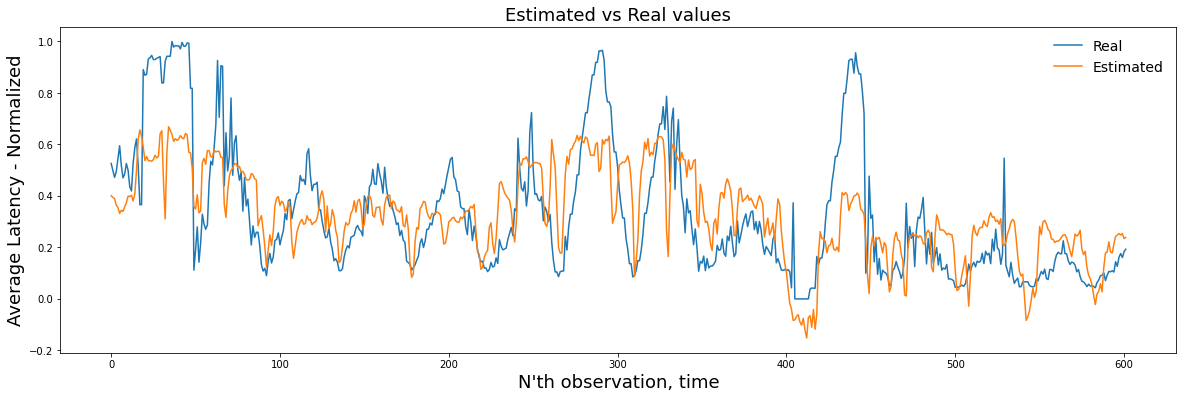

In [438]:
timeline_plot(y_train, y_pred_train)

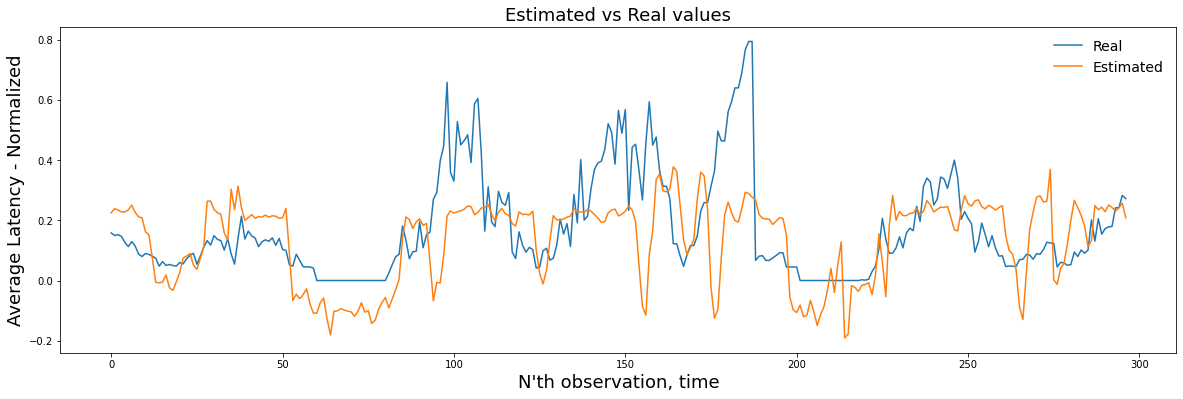

In [439]:
timeline_plot(y_test, y_pred_test)

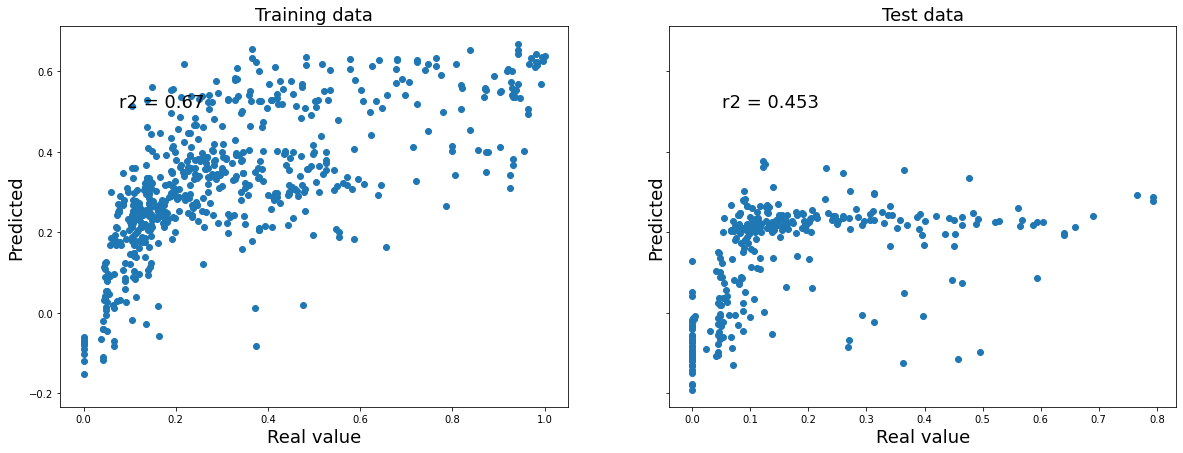

In [440]:
train_test_real_predicted_scatter(y_train, y_test, y_pred_train, y_pred_test)

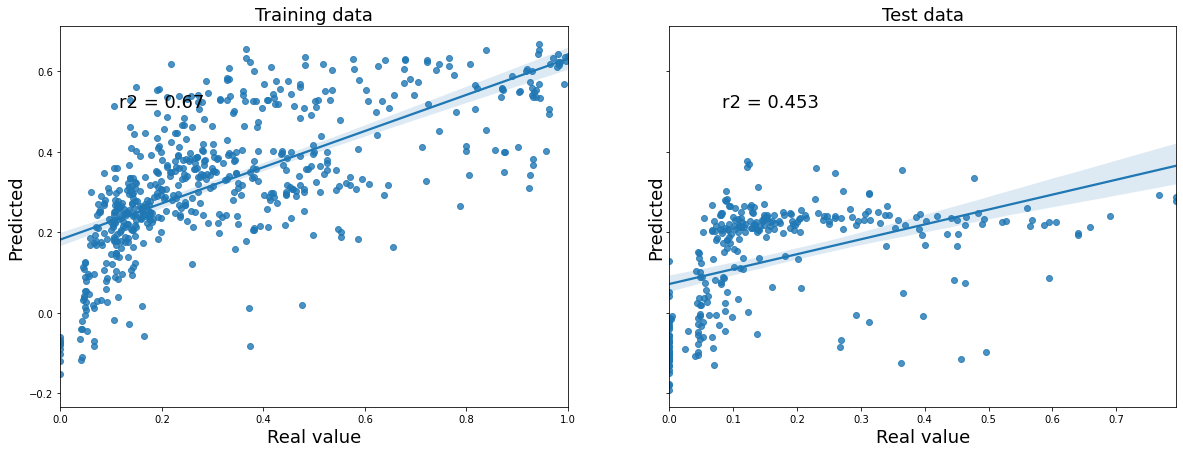

In [441]:
train_test_real_predicted_scatter_sns(y_train, y_test, y_pred_train, y_pred_test)

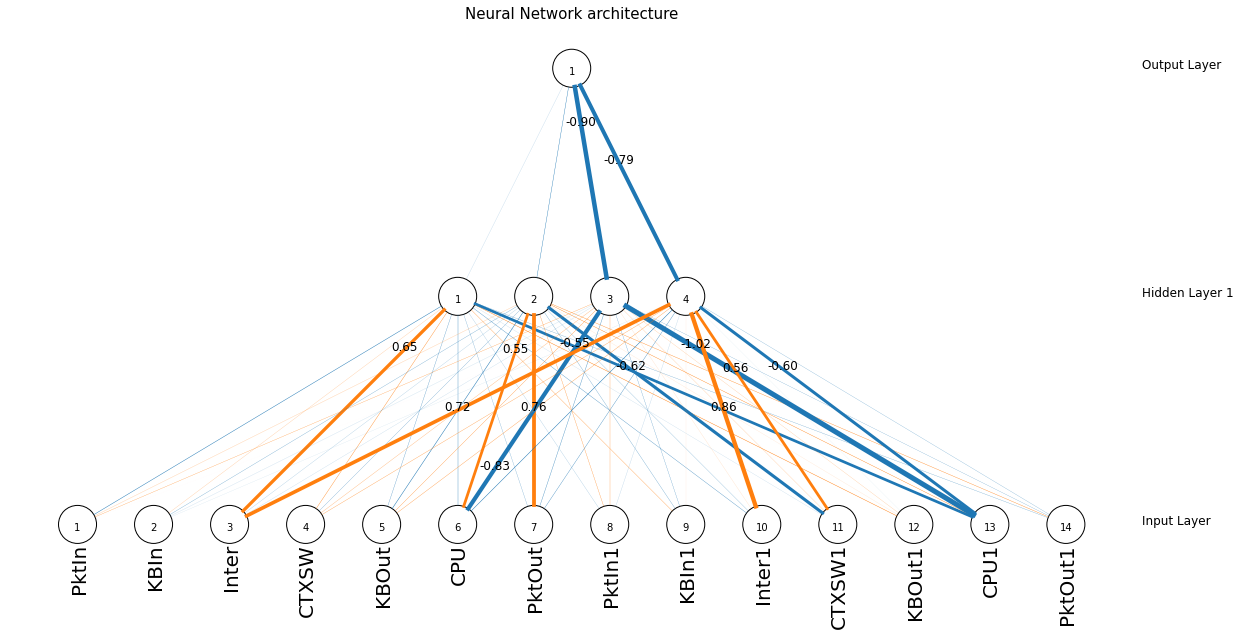

In [442]:
# Define the structure of the network
network_structure = np.hstack(([len(columns)], np.asarray(mlp.hidden_layer_sizes), [1]))

# Draw the Neural Network with weights
network=DrawNN(network_structure, mlp.coefs_, columns)
# network=DrawNN([3,4,1])
network.draw()

In [ ]:
# NN request rate nélkül laggal összetettem neurális hálóval

In [443]:
ba.columns

Index(['timestamp', 'PktIn', 'KBIn', 'AVG_RR', 'Inter', 'CTXSW', 'KBOut',
       'CPU', 'SUM_RR', 'PktOut', 'vm_number', 'AVG_LAT_05', 'timestamp1',
       'PktIn1', 'KBIn1', 'AVG_RR1', 'Inter1', 'CTXSW1', 'KBOut1', 'CPU1',
       'SUM_RR1', 'PktOut1', 'vm_number1', 'AVG_LAT_051'],
      dtype='object')

In [393]:
columns = ['PktIn', 'KBIn', 'Inter', 'CTXSW', 'KBOut', 'CPU', 'PktOut',
           'PktIn1', 'KBIn1', 'Inter1', 'CTXSW1', 'KBOut1', 'CPU1', 'PktOut1']

X = ba[columns].values
y = ba['AVG_LAT_05']

min_max_scaler = preprocessing.MinMaxScaler()
X_scaled = min_max_scaler.fit_transform(X)
y_scaled = min_max_scaler.fit_transform(y.values.reshape(-1, 1))

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.33, random_state=1, shuffle=False)

activation_function = 'tanh'        # tanh, relu, logistic

mlp = MLPRegressor(hidden_layer_sizes=(10,4),
                           max_iter=500,
                           activation=activation_function,
                           solver="lbfgs",
                           learning_rate="constant",
                           learning_rate_init=0.01,
                           alpha=0.01,
                           verbose=False,
                           momentum=0.9,
                           early_stopping=False,
                           tol=0.00000001,
                           shuffle=False,
                           # n_iter_no_change=20, \
                           random_state=1234)


mlp.fit(X_train, y_train)

y_pred_train = mlp.predict(X_train)
y_pred_test  = mlp.predict(X_test)

r2_train = np.corrcoef(y_train.ravel(), y_pred_train)[0,1]
r2_test  = np.corrcoef(y_test.ravel(), y_pred_test)[0,1]

print('r2 train = ', r2_train)
print('r2 test  = ', r2_test)

r2 train =  0.8749000868611717
r2 test  =  0.6135128021335784


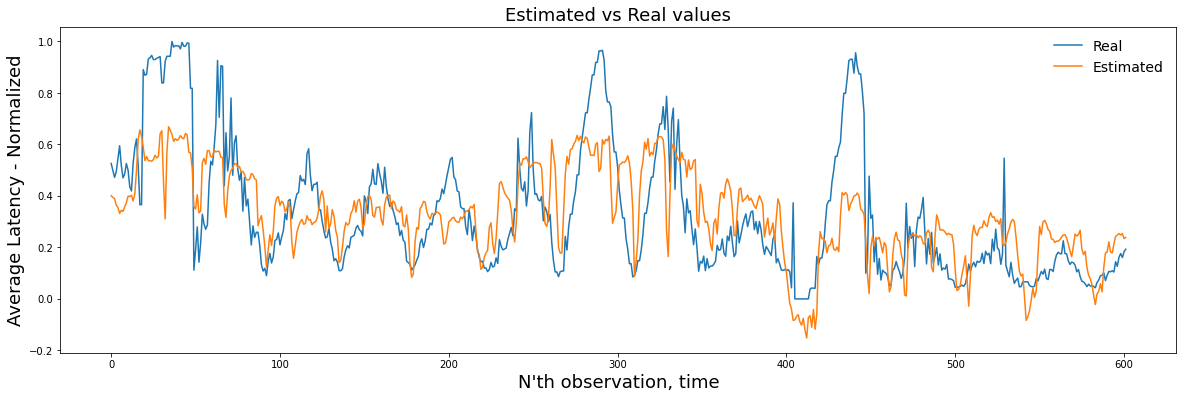

In [444]:
timeline_plot(y_train, y_pred_train)

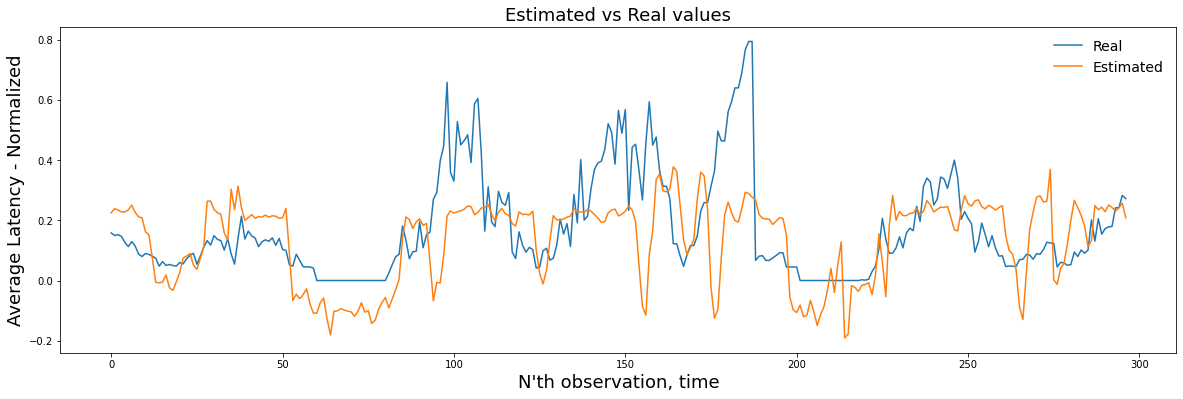

In [445]:
timeline_plot(y_test, y_pred_test)

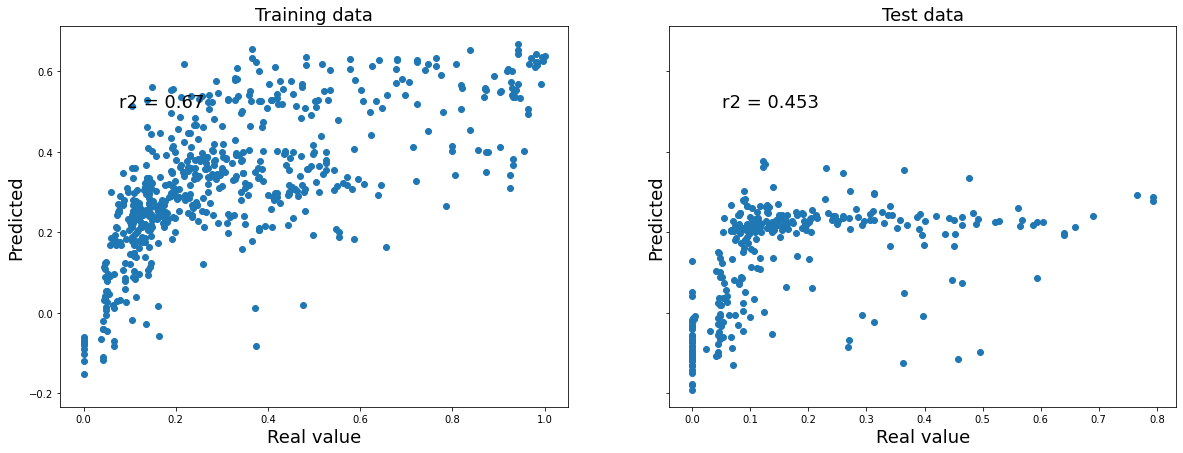

In [447]:
train_test_real_predicted_scatter(y_train, y_test, y_pred_train, y_pred_test)

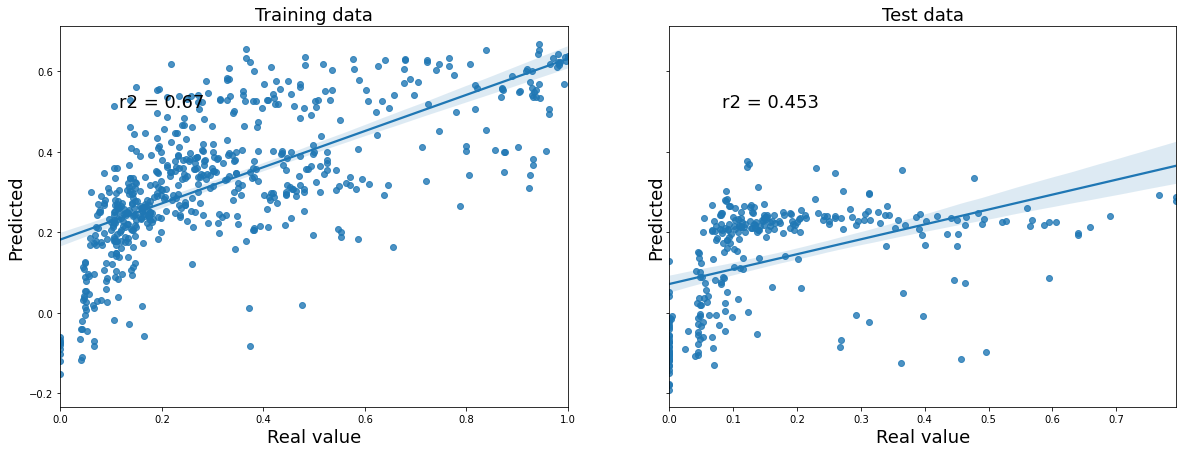

In [448]:
train_test_real_predicted_scatter_sns(y_train, y_test, y_pred_train, y_pred_test)

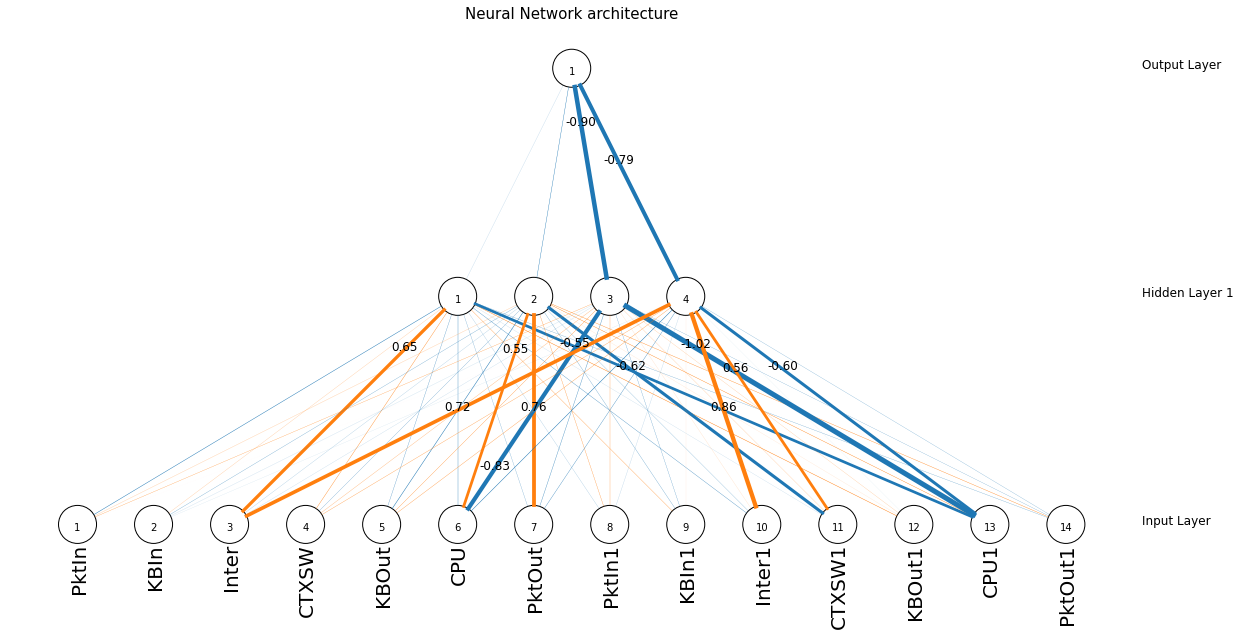

In [449]:
# Define the structure of the network
network_structure = np.hstack(([len(columns)], np.asarray(mlp.hidden_layer_sizes), [1]))

# Draw the Neural Network with weights
network=DrawNN(network_structure, mlp.coefs_, columns)
# network=DrawNN([3,4,1])
network.draw()

In [450]:
# NN, lag nélkül és laggal

In [451]:
df.columns

Index(['timestamp', 'PktIn', 'KBIn', 'AVG_RR', 'Inter', 'CTXSW', 'KBOut',
       'CPU', 'SUM_RR', 'PktOut', 'vm_number', 'AVG_LAT_05'],
      dtype='object')

In [463]:
columns = ['AVG_RR', 'SUM_RR', 'PktIn', 'KBIn', 'Inter', 'CTXSW', 'KBOut', 'CPU', 'PktOut']

X = df[columns].values
y = df['AVG_LAT_05']

min_max_scaler = preprocessing.MinMaxScaler()
X_scaled = min_max_scaler.fit_transform(X)
y_scaled = min_max_scaler.fit_transform(y.values.reshape(-1, 1))

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.33, random_state=1, shuffle=False)

activation_function = 'relu'        # tanh, relu, logistic

mlp = MLPRegressor(hidden_layer_sizes=(10,4),
                           max_iter=500,
                           activation=activation_function,
                           solver="lbfgs",
                           learning_rate="constant",
                           learning_rate_init=0.01,
                           alpha=0.01,
                           verbose=False,
                           momentum=0.9,
                           early_stopping=False,
                           tol=0.00000001,
                           shuffle=False,
                           # n_iter_no_change=20, \
                           random_state=1234)


mlp.fit(X_train, y_train)

y_pred_train = mlp.predict(X_train)
y_pred_test  = mlp.predict(X_test)

r2_train = np.corrcoef(y_train.ravel(), y_pred_train)[0,1]
r2_test  = np.corrcoef(y_test.ravel(), y_pred_test)[0,1]

print('r2 train = ', r2_train)
print('r2 test  = ', r2_test)

r2 train =  0.892536492236413
r2 test  =  0.6024888389804552


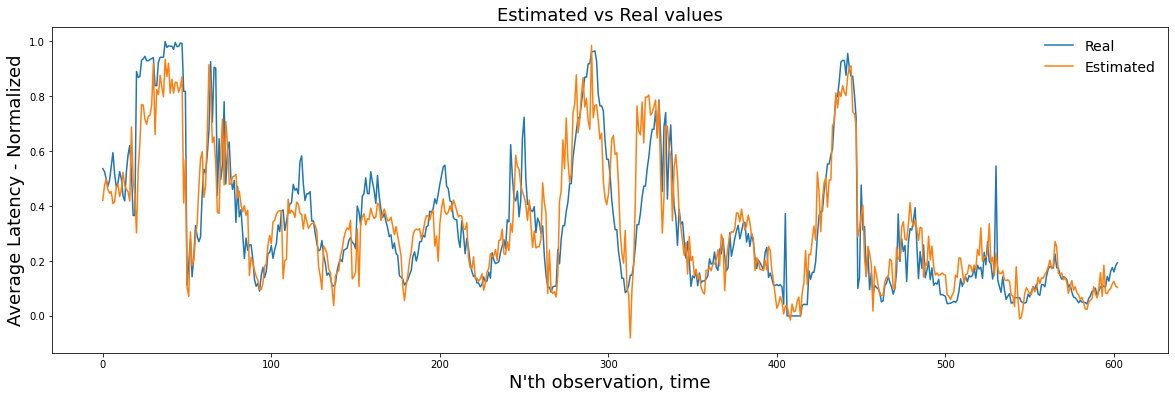

In [464]:
timeline_plot(y_train, y_pred_train)

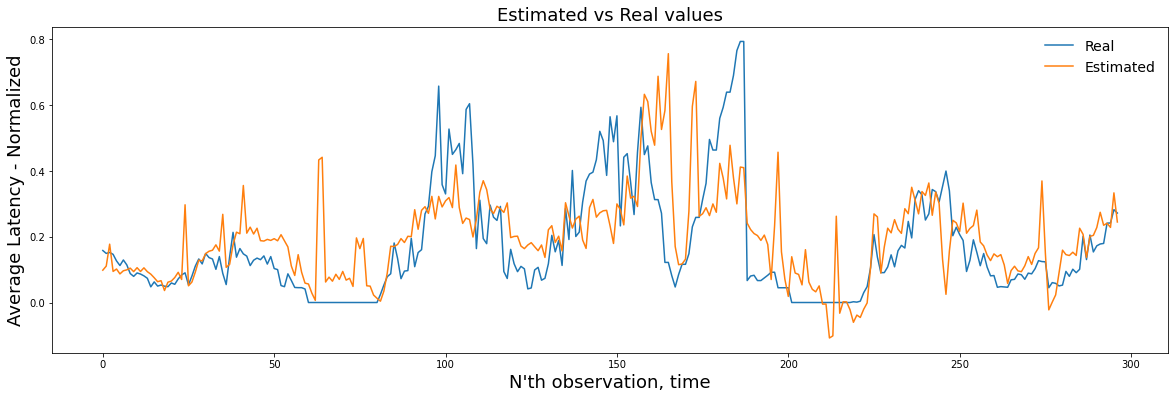

In [465]:
timeline_plot(y_test, y_pred_test)

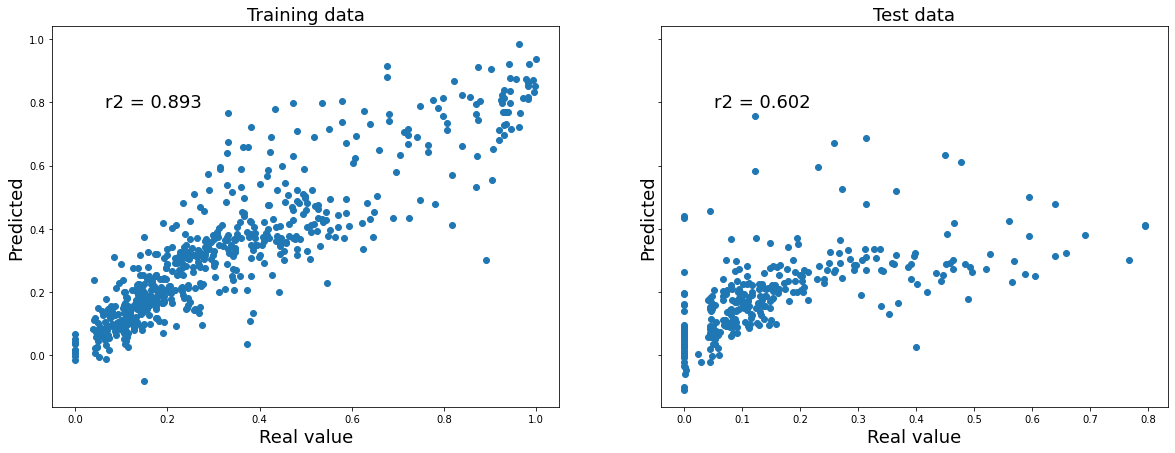

In [466]:
train_test_real_predicted_scatter(y_train, y_test, y_pred_train, y_pred_test)

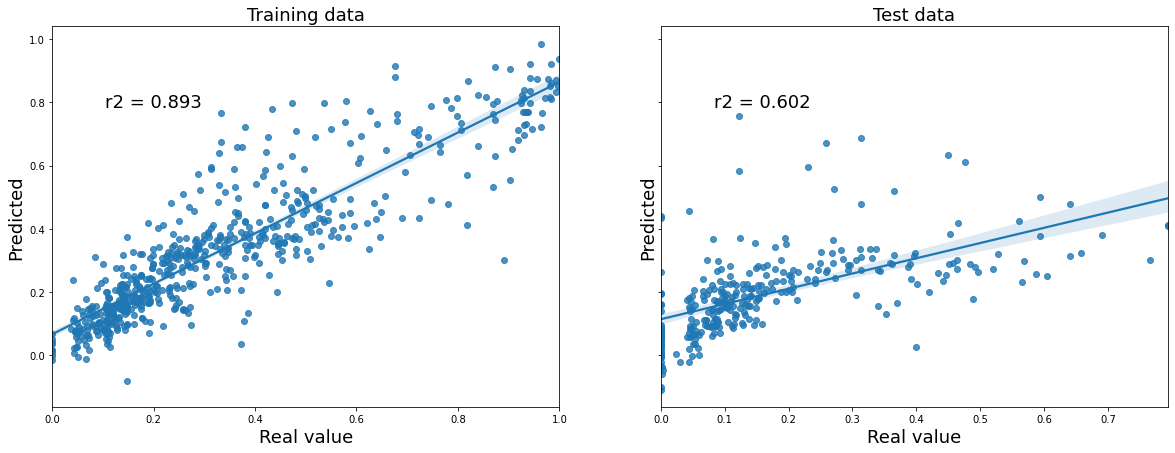

In [467]:
train_test_real_predicted_scatter_sns(y_train, y_test, y_pred_train, y_pred_test)

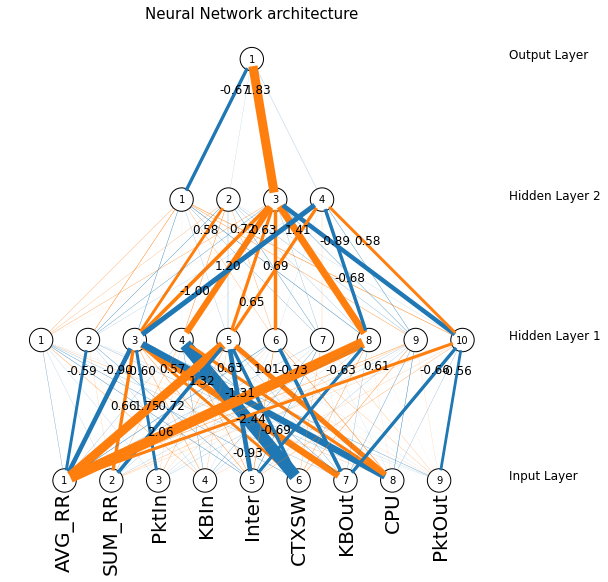

In [468]:
# Define the structure of the network
network_structure = np.hstack(([len(columns)], np.asarray(mlp.hidden_layer_sizes), [1]))

# Draw the Neural Network with weights
network=DrawNN(network_structure, mlp.coefs_, columns)
# network=DrawNN([3,4,1])
network.draw()

In [469]:
# NN laggal

In [470]:
ba.columns

Index(['timestamp', 'PktIn', 'KBIn', 'AVG_RR', 'Inter', 'CTXSW', 'KBOut',
       'CPU', 'SUM_RR', 'PktOut', 'vm_number', 'AVG_LAT_05', 'timestamp1',
       'PktIn1', 'KBIn1', 'AVG_RR1', 'Inter1', 'CTXSW1', 'KBOut1', 'CPU1',
       'SUM_RR1', 'PktOut1', 'vm_number1', 'AVG_LAT_051'],
      dtype='object')

In [471]:
columns = ['AVG_RR', 'SUM_RR', 'PktIn', 'KBIn', 'Inter', 'CTXSW', 'KBOut', 'CPU', 'PktOut', 'AVG_RR1', 'SUM_RR1', 'PktIn1', 'KBIn1', 'Inter1', 'CTXSW1', 'KBOut1', 'CPU1',
       'PktOut1']

X = ba[columns].values
y = ba['AVG_LAT_05']

min_max_scaler = preprocessing.MinMaxScaler()
X_scaled = min_max_scaler.fit_transform(X)
y_scaled = min_max_scaler.fit_transform(y.values.reshape(-1, 1))

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.33, random_state=1, shuffle=False)

activation_function = 'relu'        # tanh, relu, logistic

mlp = MLPRegressor(hidden_layer_sizes=4,
                           max_iter=500,
                           activation=activation_function,
                           solver="lbfgs",
                           learning_rate="constant",
                           learning_rate_init=0.01,
                           alpha=0.01,
                           verbose=False,
                           momentum=0.9,
                           early_stopping=False,
                           tol=0.00000001,
                           shuffle=False,
                           # n_iter_no_change=20, \
                           random_state=1234)


mlp.fit(X_train, y_train)

y_pred_train = mlp.predict(X_train)
y_pred_test  = mlp.predict(X_test)

r2_train = np.corrcoef(y_train.ravel(), y_pred_train)[0,1]
r2_test  = np.corrcoef(y_test.ravel(), y_pred_test)[0,1]

print('r2 train = ', r2_train)
print('r2 test  = ', r2_test)

r2 train =  0.8379600241200471
r2 test  =  0.6016419565226497


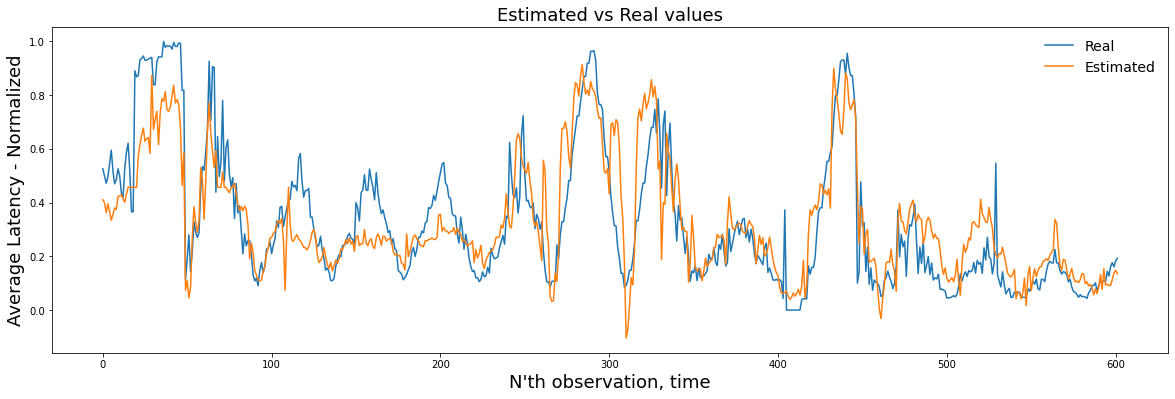

In [473]:
timeline_plot(y_train, y_pred_train)

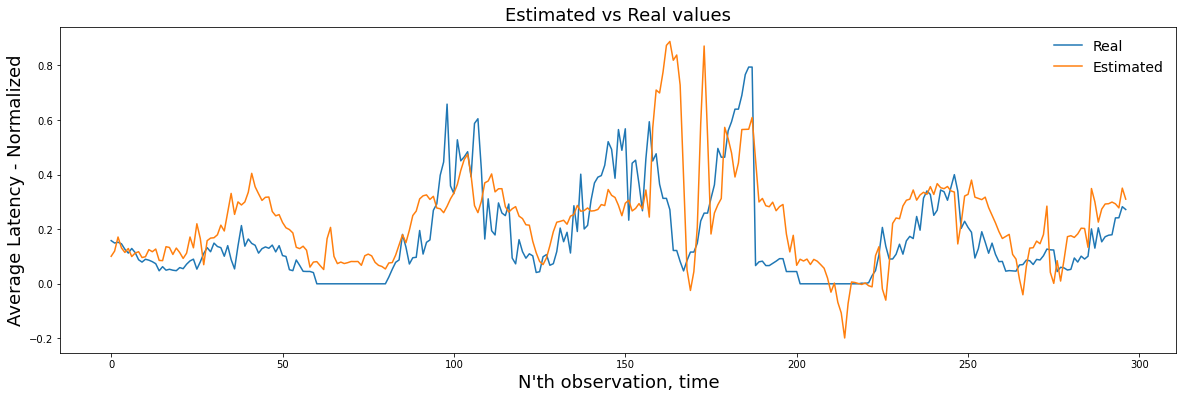

In [474]:
timeline_plot(y_test, y_pred_test)

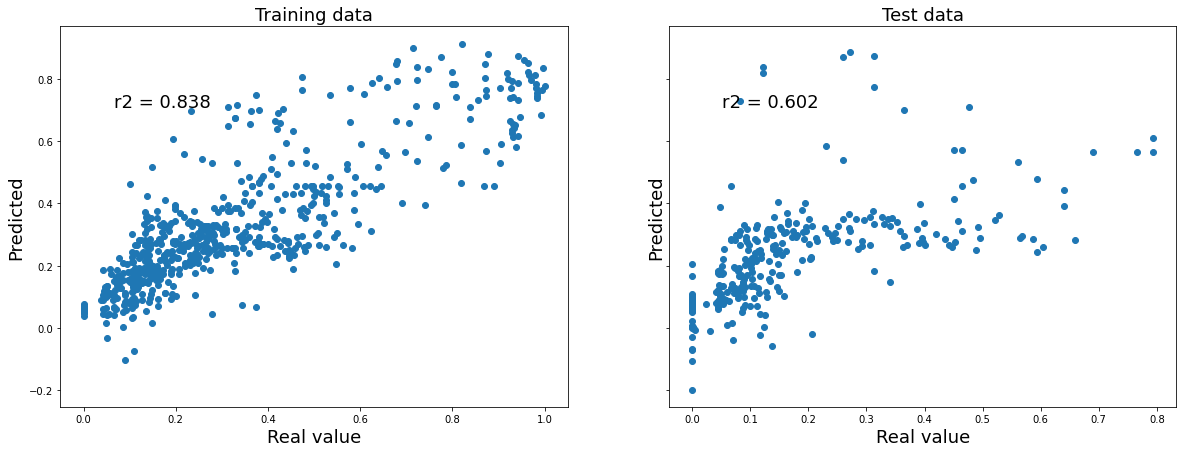

In [475]:
train_test_real_predicted_scatter(y_train, y_test, y_pred_train, y_pred_test)

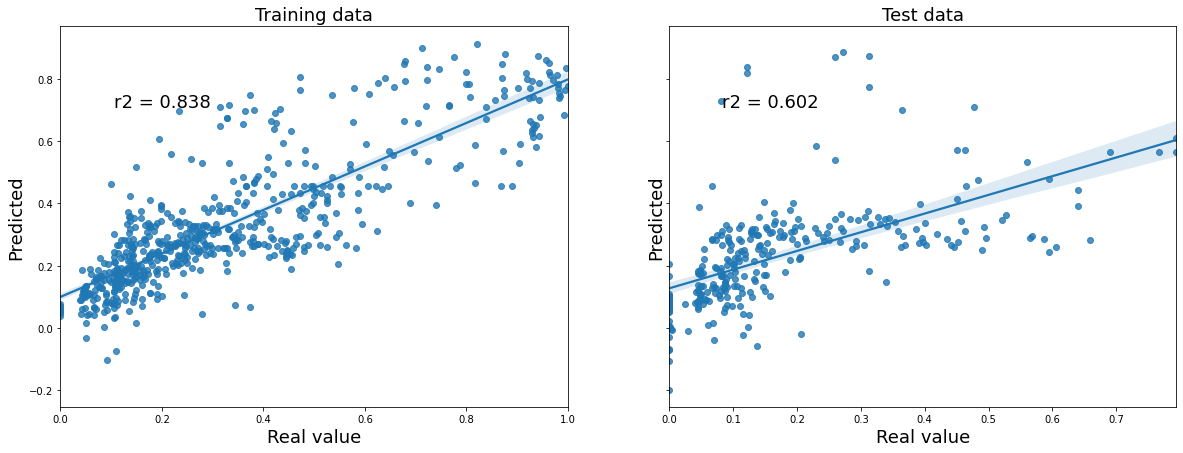

In [476]:
train_test_real_predicted_scatter_sns(y_train, y_test, y_pred_train, y_pred_test)

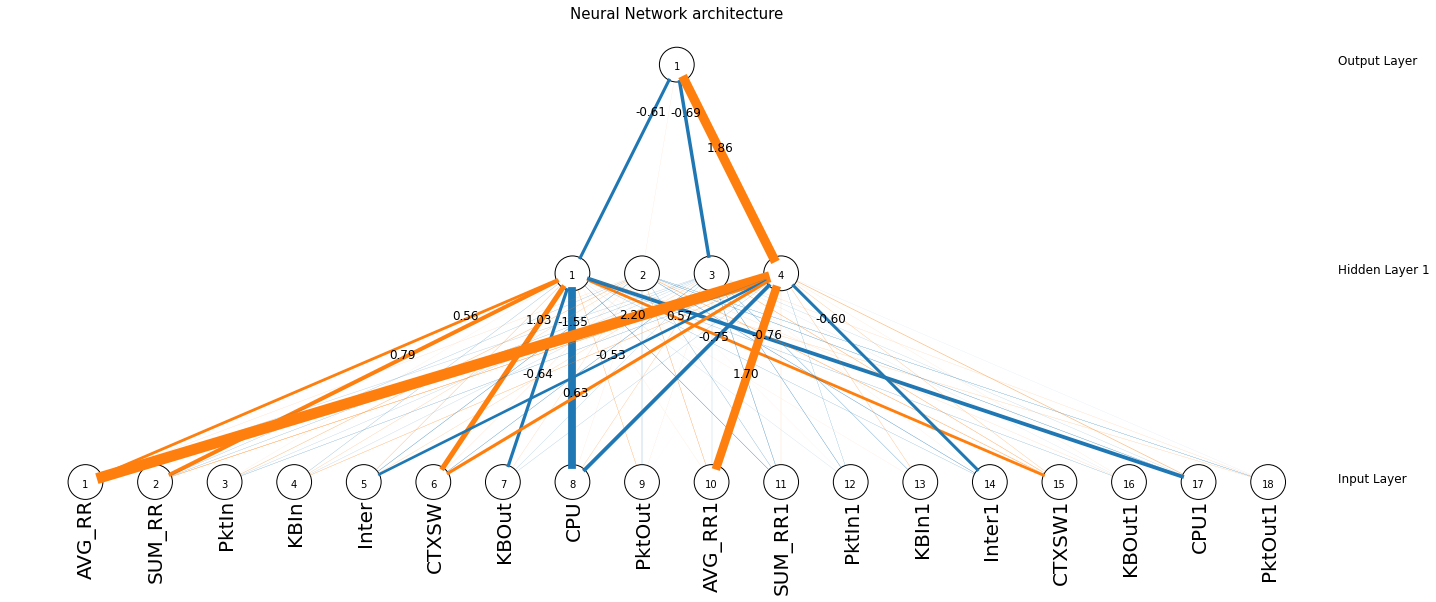

In [477]:
# Define the structure of the network
network_structure = np.hstack(([len(columns)], np.asarray(mlp.hidden_layer_sizes), [1]))

# Draw the Neural Network with weights
network=DrawNN(network_structure, mlp.coefs_, columns)
# network=DrawNN([3,4,1])
network.draw()

In [478]:
# kumulatív hiba számolásával

In [534]:

columns = ['AVG_RR', 'SUM_RR', 'PktIn', 'KBIn', 'Inter', 'CTXSW', 'KBOut', 'CPU', 'PktOut', 'AVG_RR1', 'SUM_RR1', 'PktIn1', 'KBIn1', 'Inter1', 'CTXSW1', 'KBOut1', 'CPU1',
       'PktOut1']

X = ba[columns].values
y = ba['AVG_LAT_05']


errors = []
cummulative_errors = []
y_predicted = np.zeros(len(X))
y_real = np.zeros(len(X))
cummulative_error = 0
start = 100
stop = 880
for i in range(start, stop):

  min_max_scaler = preprocessing.MinMaxScaler()
  X_scaled = min_max_scaler.fit_transform(X)
  y_scaled = min_max_scaler.fit_transform(y.values.reshape(-1, 1))

  X_train = X_scaled[0:i,:]
  y_train = y_scaled[0:i,:]
  X_test  = X_scaled[i:i+1,:]
  y_test  = y_scaled[i:i+1,:]


  activation_function = 'relu'        # tanh, relu, logistic

  mlp = MLPRegressor(hidden_layer_sizes=4,
                            max_iter=500,
                            activation=activation_function,
                            solver="lbfgs",
                            learning_rate="constant",
                            learning_rate_init=0.01,
                            alpha=0.01,
                            verbose=False,
                            momentum=0.9,
                            early_stopping=False,
                            tol=0.00000001,
                            shuffle=False,
                            # n_iter_no_change=20, \
                            random_state=1234)


  mlp.fit(X_train, y_train)

  y_pred_train = mlp.predict(X_train)
  y_pred_test  = mlp.predict(X_test)

  r2_train = np.corrcoef(y_train.ravel(), y_pred_train)[0,1]
  r2_test  = np.corrcoef(y_test.ravel(), y_pred_test)[0,1]

  # print('r2 train = ', r2_train)

  error = y_test[0]-y_pred_test[0]
  abs_error = abs(error)
  errors.append(abs_error)
  cummulative_error = cummulative_error + abs_error
  # print(cummulative_error)
  cummulative_errors.append(cummulative_error)
  y_predicted[i+1] = y_pred_test[0]
  y_real[i+1] = y_test[0]

  if( i % 50 == 0 ):
    print('step = ', i, '\t', 'r2 = ', np.corrcoef(y_real, y_predicted)[0,1])


step =  100 	 r2 =  0.9999999999999922
step =  150 	 r2 =  0.92481403277532
step =  200 	 r2 =  0.9449331371570554
step =  250 	 r2 =  0.9144005284894046
step =  300 	 r2 =  0.8935448562889301
step =  350 	 r2 =  0.8747488096826802
step =  400 	 r2 =  0.873048285145508
step =  450 	 r2 =  0.8480048011971928
step =  500 	 r2 =  0.8245658367212062
step =  550 	 r2 =  0.8106952391873032
step =  600 	 r2 =  0.7988055419878551
step =  650 	 r2 =  0.7897117526489917
step =  700 	 r2 =  0.7816345474106412
step =  750 	 r2 =  0.766192212469738
step =  800 	 r2 =  0.7311231362523145
step =  850 	 r2 =  0.7190250617547258


[104.0299433]


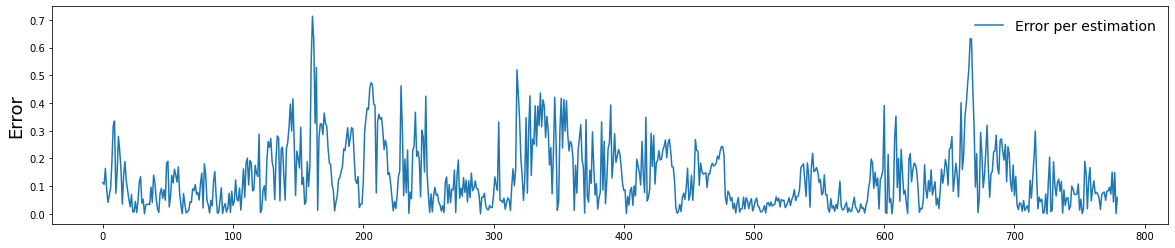

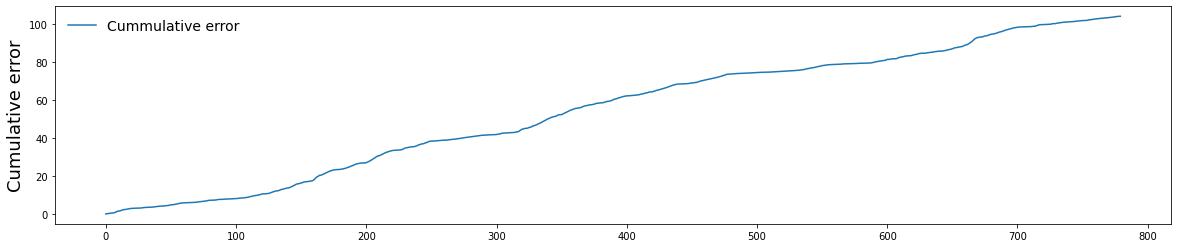

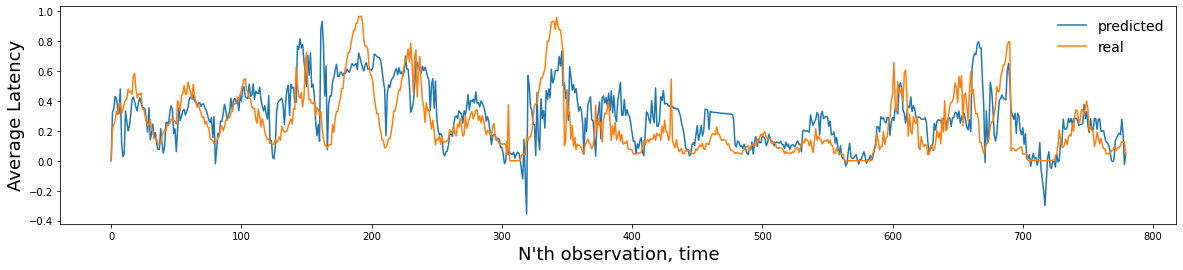

In [536]:
print(cummulative_error)

cummulative_plots(errors, cummulative_errors, y_real[100:880], y_predicted[100:880])

In [492]:
r2 = np.corrcoef(y_real, y_predicted)[0,1]

r2

0.7094788126849647

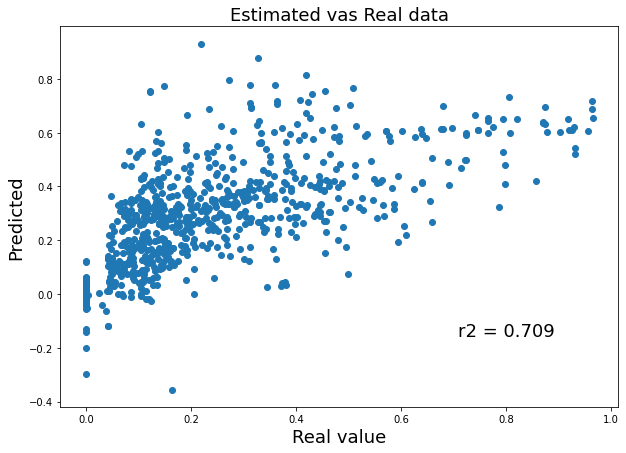

In [500]:
cummaulative_real_predicted_scatter(y_real, y_predicted)

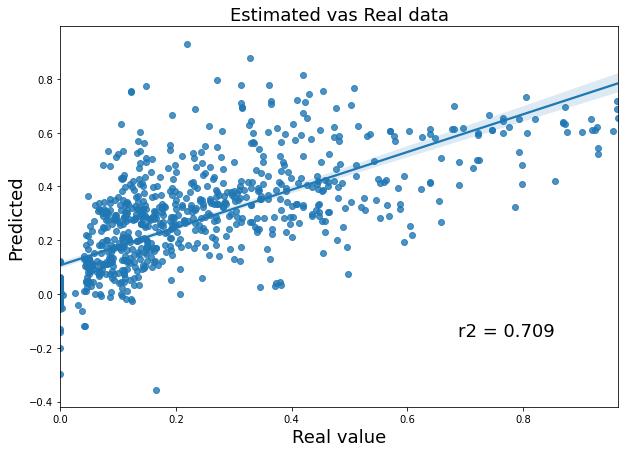

In [504]:
cummaulative_real_predicted_scatter_sns(y_real, y_predicted)

In [506]:

columns = ['AVG_RR', 'SUM_RR', 'PktIn', 'KBIn', 'Inter', 'CTXSW', 'KBOut', 'CPU', 'PktOut', 'AVG_RR1', 'SUM_RR1', 'PktIn1', 'KBIn1', 'Inter1', 'CTXSW1', 'KBOut1', 'CPU1',
       'PktOut1']

X = ba[columns].values
y = ba['AVG_LAT_05']


errors = []
cummulative_errors = []
y_predicted = np.zeros(len(X))
y_real = np.zeros(len(X))
cummulative_error = 0
start = 100
stop = 880
for i in range(start, stop):

  min_max_scaler = preprocessing.MinMaxScaler()
  X_scaled = min_max_scaler.fit_transform(X)
  y_scaled = min_max_scaler.fit_transform(y.values.reshape(-1, 1))

  X_train = X_scaled[0:i,:]
  y_train = y_scaled[0:i,:]
  X_test  = X_scaled[i:i+1,:]
  y_test  = y_scaled[i:i+1,:]


  activation_function = 'relu'        # tanh, relu, logistic

  mlp = MLPRegressor(hidden_layer_sizes=4,
                            max_iter=500,
                            activation=activation_function,
                            solver="lbfgs",
                            learning_rate="constant",
                            learning_rate_init=0.01,
                            alpha=0.01,
                            verbose=False,
                            momentum=0.9,
                            early_stopping=False,
                            tol=0.00000001,
                            shuffle=False,
                            # n_iter_no_change=20, \
                            random_state=1234)


  mlp.fit(X_train, y_train)

  y_pred_train = mlp.predict(X_train)
  y_pred_test  = mlp.predict(X_test)

  r2_train = np.corrcoef(y_train.ravel(), y_pred_train)[0,1]
  r2_test  = np.corrcoef(y_test.ravel(), y_pred_test)[0,1]

  # print('r2 train = ', r2_train)

  error = y_test[0]-y_pred_test[0]
  abs_error = abs(error)
  errors.append(abs_error)
  cummulative_error = cummulative_error + abs_error
  # print(cummulative_error)
  cummulative_errors.append(cummulative_error)
  y_predicted[i+1] = y_pred_test[0]
  y_real[i+1] = y_test[0]

  if( i % 50 == 0 ):
    print('step = ', i, '\t', 'r2 = ', np.corrcoef(y_real, y_predicted)[0,1])


step =  100 	 r2 =  0.9999999999999922
step =  150 	 r2 =  0.92481403277532
step =  200 	 r2 =  0.9449331371570554
step =  250 	 r2 =  0.9144005284894046
step =  300 	 r2 =  0.8935448562889301
step =  350 	 r2 =  0.8747488096826802
step =  400 	 r2 =  0.873048285145508
step =  450 	 r2 =  0.8480048011971928
step =  500 	 r2 =  0.8245658367212062
step =  550 	 r2 =  0.8106952391873032
step =  600 	 r2 =  0.7988055419878551
step =  650 	 r2 =  0.7897117526489917
step =  700 	 r2 =  0.7816345474106412
step =  750 	 r2 =  0.766192212469738
step =  800 	 r2 =  0.7311231362523145
step =  850 	 r2 =  0.7190250617547258


[104.0299433]


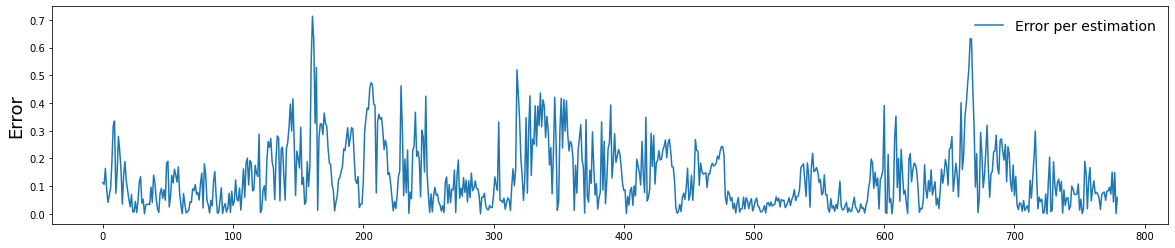

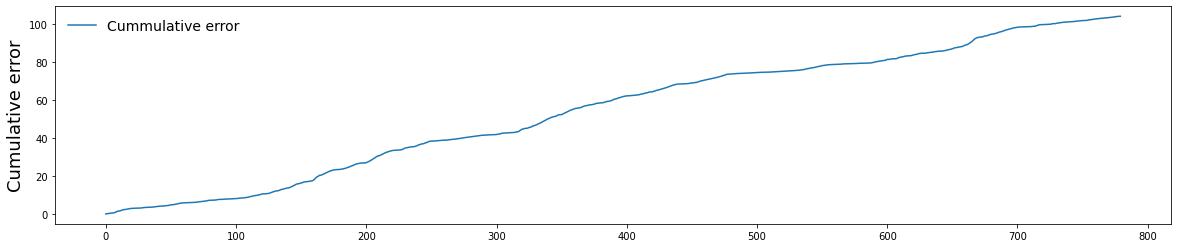

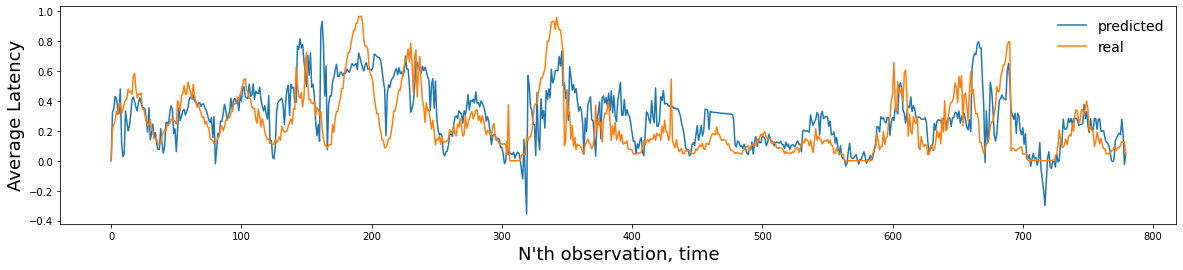

In [512]:
print(cummulative_error)

cummulative_plots(errors, cummulative_errors, y_real[100:880], y_predicted[100:880])

In [515]:
r2 = np.corrcoef(y_real, y_predicted)[0,1]

r2

0.7094788126849647

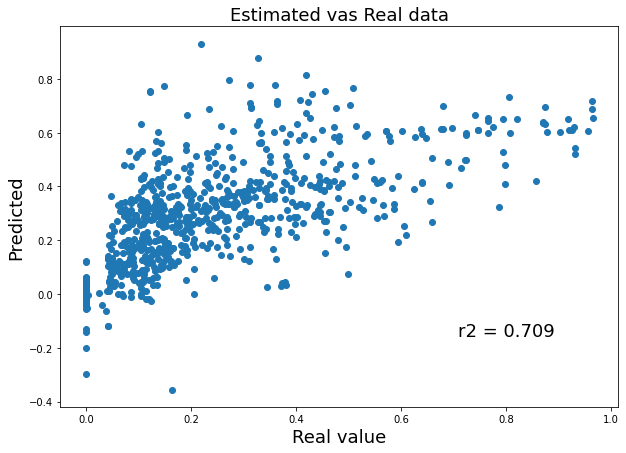

In [516]:
cummaulative_real_predicted_scatter(y_real, y_predicted)

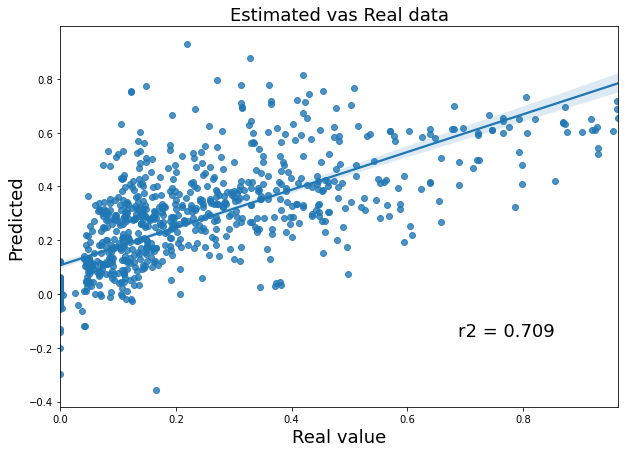

In [517]:
cummaulative_real_predicted_scatter_sns(y_real, y_predicted)

In [518]:
# lagok nélküli futó hiba

In [519]:
X = ba[['AVG_RR', 'SUM_RR', 'PktIn', 'KBIn', 'Inter', 'CTXSW', 'KBOut', 'CPU', 'PktOut']].values
y = ba['AVG_LAT_05']


errors = []
cummulative_errors = []
y_predicted = np.zeros(len(X))
y_real = np.zeros(len(X))
cummulative_error = 0
start = 100
stop = 880
for i in range(start, stop):

  min_max_scaler = preprocessing.MinMaxScaler()
  X_scaled = min_max_scaler.fit_transform(X)
  y_scaled = min_max_scaler.fit_transform(y.values.reshape(-1, 1))

  X_train = X_scaled[0:i,:]
  y_train = y_scaled[0:i,:]
  X_test  = X_scaled[i:i+1,:]
  y_test  = y_scaled[i:i+1,:]

  activation_function = 'relu'        # tanh, relu, logistic

  mlp = MLPRegressor(hidden_layer_sizes=4,
                            max_iter=500,
                            activation=activation_function,
                            solver="lbfgs",
                            learning_rate="constant",
                            learning_rate_init=0.01,
                            alpha=0.01,
                            verbose=False,
                            momentum=0.9,
                            early_stopping=False,
                            tol=0.00000001,
                            shuffle=False,
                            # n_iter_no_change=20, \
                            random_state=1234)


  mlp.fit(X_train, y_train)

  y_pred_train = mlp.predict(X_train)
  y_pred_test  = mlp.predict(X_test)

  r2_train = np.corrcoef(y_train.ravel(), y_pred_train)[0,1]
  r2_test  = np.corrcoef(y_test.ravel(), y_pred_test)[0,1]

  # print('r2 train = ', r2_train)

  error = y_test[0]-y_pred_test[0]
  abs_error = abs(error)
  errors.append(abs_error)
  cummulative_error = cummulative_error + abs_error
  # print(cummulative_error)
  cummulative_errors.append(cummulative_error)
  y_predicted[i+1] = y_pred_test[0]
  y_real[i+1] = y_test[0]

  if( i % 50 == 0 ):
    print('step = ', i, '\t', 'r2 = ', np.corrcoef(y_real, y_predicted)[0,1])


step =  100 	 r2 =  1.0
step =  150 	 r2 =  0.9230036831674362
step =  200 	 r2 =  0.9345356146925362
step =  250 	 r2 =  0.9191809109571992
step =  300 	 r2 =  0.8971001876258204
step =  350 	 r2 =  0.880995146355581
step =  400 	 r2 =  0.8767587497072864
step =  450 	 r2 =  0.8482098138710269
step =  500 	 r2 =  0.833450859456239
step =  550 	 r2 =  0.8214425962307896
step =  600 	 r2 =  0.8126697126869334
step =  650 	 r2 =  0.8051660649089737
step =  700 	 r2 =  0.7961261216628002
step =  750 	 r2 =  0.7793234985900821
step =  800 	 r2 =  0.7508250094752911
step =  850 	 r2 =  0.7400091163887844


[103.34493023]


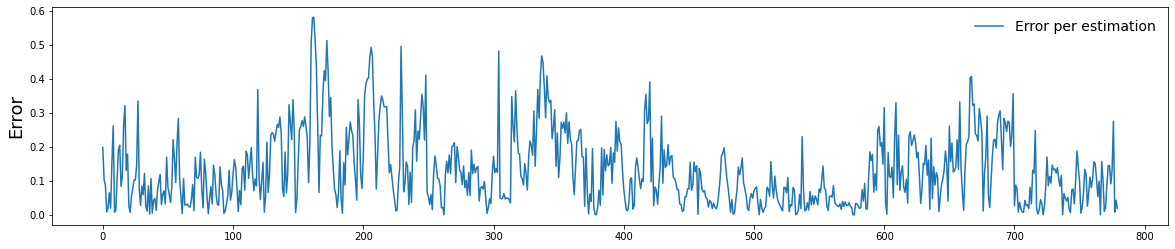

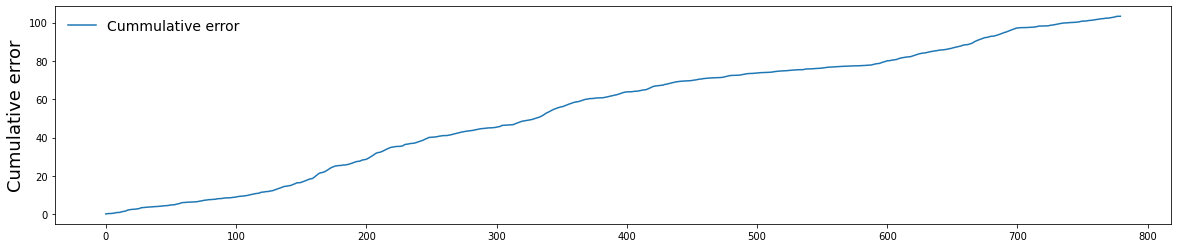

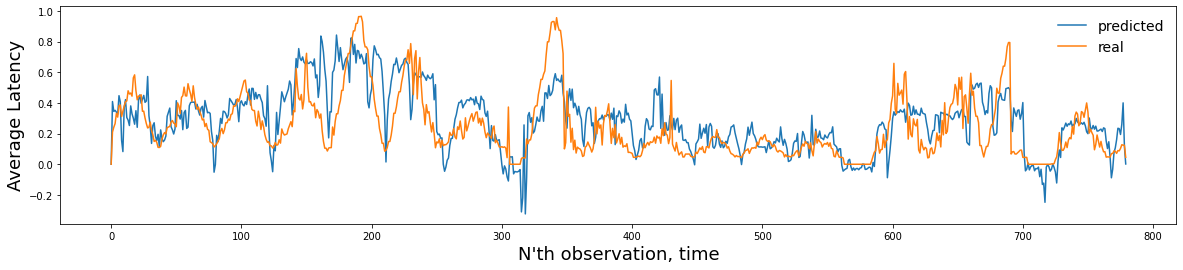

In [522]:
print(cummulative_error)

cummulative_plots(errors, cummulative_errors, y_real[100:880], y_predicted[100:880])

In [523]:
r2 = np.corrcoef(y_real, y_predicted)[0,1]

r2

0.7303630273946106

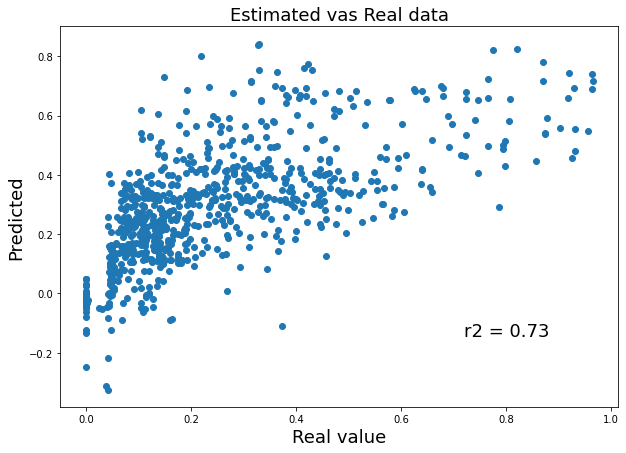

In [524]:
cummaulative_real_predicted_scatter(y_real, y_predicted)

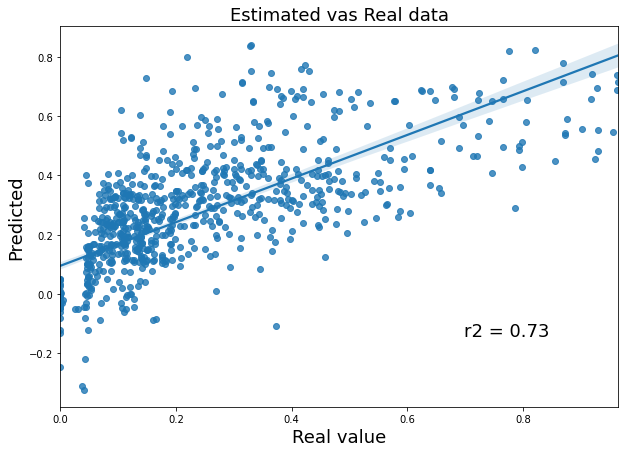

In [525]:
cummaulative_real_predicted_scatter_sns(y_real, y_predicted)

In [527]:
# lagok nélküli futó hiba összetetteb hálóval

In [528]:
X = ba[['AVG_RR', 'SUM_RR', 'PktIn', 'KBIn', 'Inter', 'CTXSW', 'KBOut', 'CPU', 'PktOut']].values
y = ba['AVG_LAT_05']


errors = []
cummulative_errors = []
y_predicted = np.zeros(len(X))
y_real = np.zeros(len(X))
cummulative_error = 0
start = 100
stop = 880
for i in range(start, stop):

  min_max_scaler = preprocessing.MinMaxScaler()
  X_scaled = min_max_scaler.fit_transform(X)
  y_scaled = min_max_scaler.fit_transform(y.values.reshape(-1, 1))

  X_train = X_scaled[0:i,:]
  y_train = y_scaled[0:i,:]
  X_test  = X_scaled[i:i+1,:]
  y_test  = y_scaled[i:i+1,:]

  activation_function = 'relu'        # tanh, relu, logistic

  mlp = MLPRegressor(hidden_layer_sizes=10,
                            max_iter=500,
                            activation=activation_function,
                            solver="lbfgs",
                            learning_rate="constant",
                            learning_rate_init=0.01,
                            alpha=0.01,
                            verbose=False,
                            momentum=0.9,
                            early_stopping=False,
                            tol=0.00000001,
                            shuffle=False,
                            # n_iter_no_change=20, \
                            random_state=1234)


  mlp.fit(X_train, y_train)

  y_pred_train = mlp.predict(X_train)
  y_pred_test  = mlp.predict(X_test)

  r2_train = np.corrcoef(y_train.ravel(), y_pred_train)[0,1]
  r2_test  = np.corrcoef(y_test.ravel(), y_pred_test)[0,1]

  error = y_test[0]-y_pred_test[0]
  abs_error = abs(error)
  errors.append(abs_error)
  cummulative_error = cummulative_error + abs_error
  # print(cummulative_error)
  cummulative_errors.append(cummulative_error)
  y_predicted[i+1] = y_pred_test[0]
  y_real[i+1] = y_test[0]

  if( i % 50 == 0 ):
    print('step = ', i, '\t', 'r2 = ', np.corrcoef(y_real, y_predicted)[0,1])


step =  100 	 r2 =  1.0
step =  150 	 r2 =  0.9399287584598617
step =  200 	 r2 =  0.9482763338829029
step =  250 	 r2 =  0.9388391581119391
step =  300 	 r2 =  0.91759061635771
step =  350 	 r2 =  0.8906653133389246
step =  400 	 r2 =  0.8887959183235419
step =  450 	 r2 =  0.8874932538945819
step =  500 	 r2 =  0.8774524553586116
step =  550 	 r2 =  0.8676668721515335
step =  600 	 r2 =  0.8608532938953687
step =  650 	 r2 =  0.8551501259650839
step =  700 	 r2 =  0.8480976341173084
step =  750 	 r2 =  0.8337881951769235
step =  800 	 r2 =  0.806242077052747
step =  850 	 r2 =  0.7968654062907513


[83.7219115]


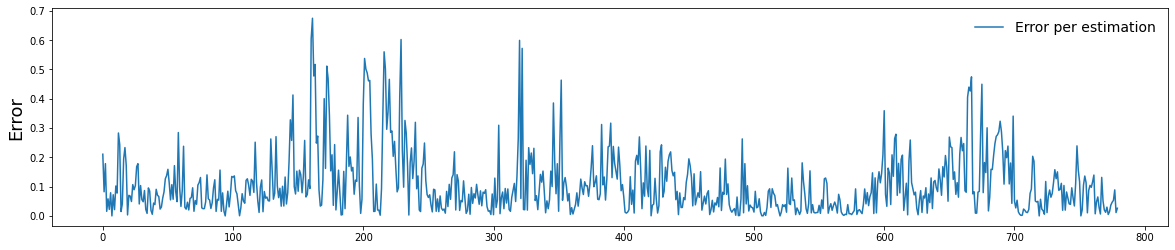

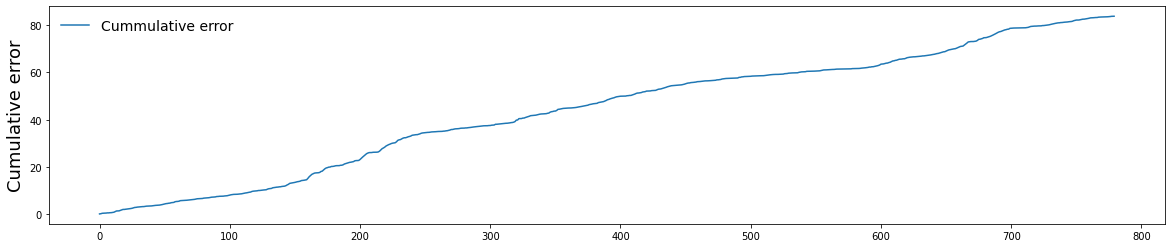

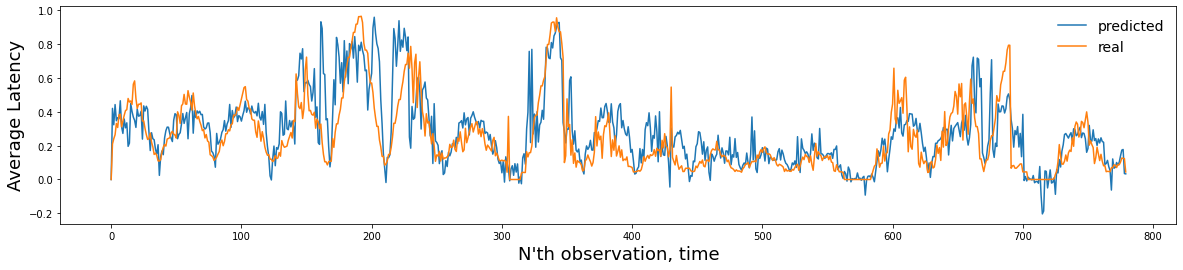

In [530]:
print(cummulative_error)

cummulative_plots(errors, cummulative_errors, y_real[100:880], y_predicted[100:880])

In [531]:
r2 = np.corrcoef(y_real, y_predicted)[0,1]

r2

0.7905652853031386

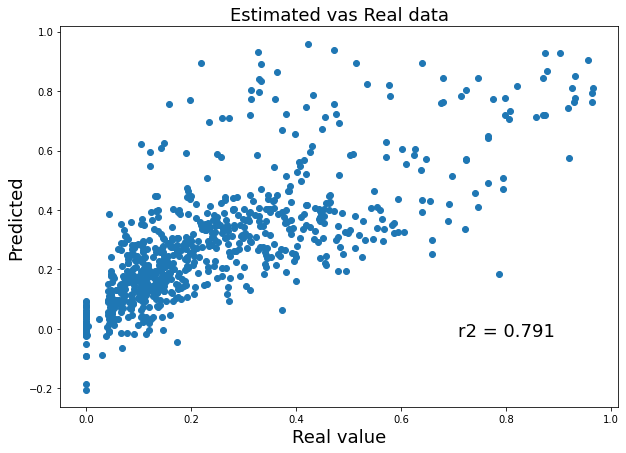

In [532]:
cummaulative_real_predicted_scatter(y_real, y_predicted)

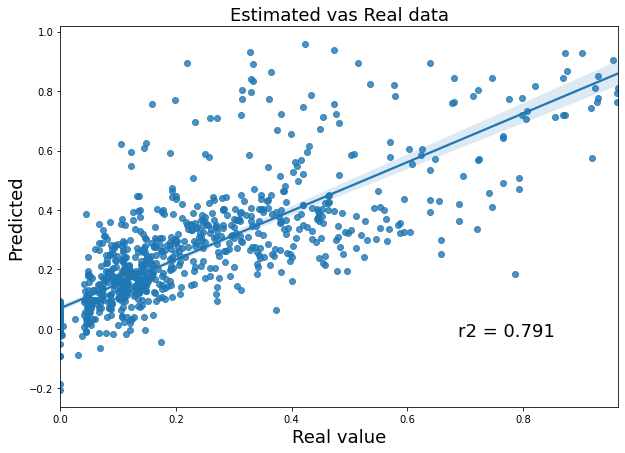

In [533]:
cummaulative_real_predicted_scatter_sns(y_real, y_predicted)

# Playground

Itt ki lehet próbálni mindeféle beállítást, és ha találok valami érdkeset akkor azt tovább lehet gondolni


In [ ]:
# NN laggal

In [537]:
ba.columns

Index(['timestamp', 'PktIn', 'KBIn', 'AVG_RR', 'Inter', 'CTXSW', 'KBOut',
       'CPU', 'SUM_RR', 'PktOut', 'vm_number', 'AVG_LAT_05', 'timestamp1',
       'PktIn1', 'KBIn1', 'AVG_RR1', 'Inter1', 'CTXSW1', 'KBOut1', 'CPU1',
       'SUM_RR1', 'PktOut1', 'vm_number1', 'AVG_LAT_051'],
      dtype='object')

In [642]:
columns = ['AVG_RR', 'SUM_RR', 'PktIn', 'KBIn', 'Inter', 'CTXSW', 'KBOut', 'CPU', 'PktOut', 'AVG_RR1', 'SUM_RR1', 'PktIn1', 'KBIn1', 'Inter1', 'CTXSW1', 'KBOut1', 'CPU1', 'PktOut1']

columns = ['PktIn', 'KBIn', 'Inter', 'CTXSW', 'KBOut', 'CPU', 'PktOut', 'PktIn1', 'KBIn1', 'Inter1', 'CTXSW1', 'KBOut1', 'CPU1', 'PktOut1']

# columns = ['AVG_RR', 'SUM_RR', 'PktIn', 'KBIn', 'Inter', 'CTXSW', 'KBOut', 'CPU', 'PktOut']


X = ba[columns].values
y = ba['AVG_LAT_05']

min_max_scaler = preprocessing.MinMaxScaler()
X_scaled = min_max_scaler.fit_transform(X)
y_scaled = min_max_scaler.fit_transform(y.values.reshape(-1, 1))

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.33, random_state=1, shuffle=False)

activation_function = 'logistic'        # tanh, relu, logistic

mlp = MLPRegressor(hidden_layer_sizes=(10,4),
                           max_iter=1000,
                           activation=activation_function,
                           solver="lbfgs",
                           learning_rate="constant",
                           learning_rate_init=0.01,
                           alpha=0.01,
                           verbose=False,
                           momentum=0.9,
                           early_stopping=False,
                           tol=0.00000001,
                           shuffle=False,
                           # n_iter_no_change=20, \
                           random_state=1234)


mlp.fit(X_train, y_train)

y_pred_train = mlp.predict(X_train)
y_pred_test  = mlp.predict(X_test)

r2_train = np.corrcoef(y_train.ravel(), y_pred_train)[0,1]
r2_test  = np.corrcoef(y_test.ravel(), y_pred_test)[0,1]

print('r2 train = ', r2_train)
print('r2 test  = ', r2_test)

r2 train =  0.8485863092857721
r2 test  =  0.5367167393952852


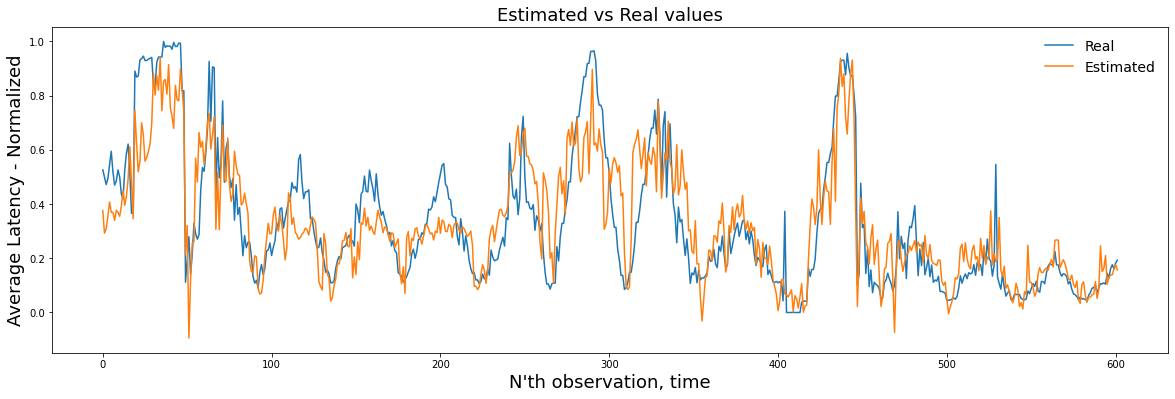

In [643]:
timeline_plot(y_train, y_pred_train)

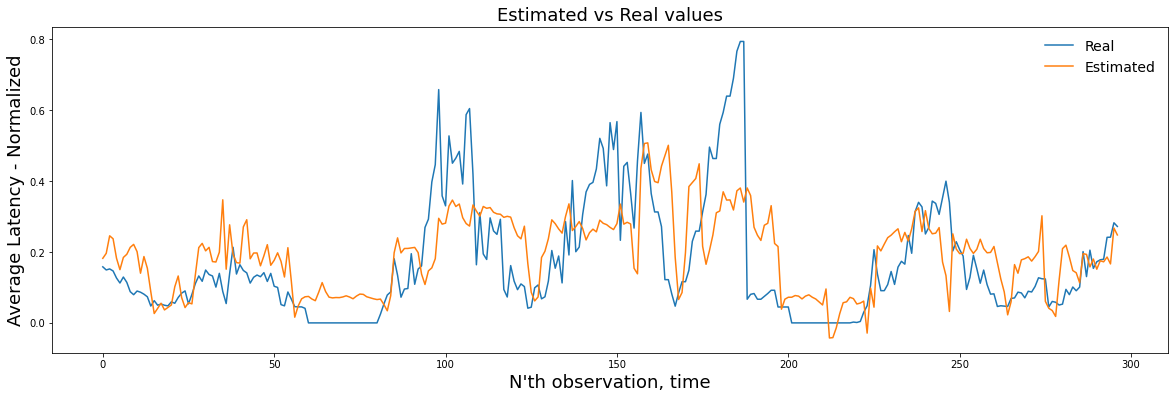

In [628]:
timeline_plot(y_test, y_pred_test)

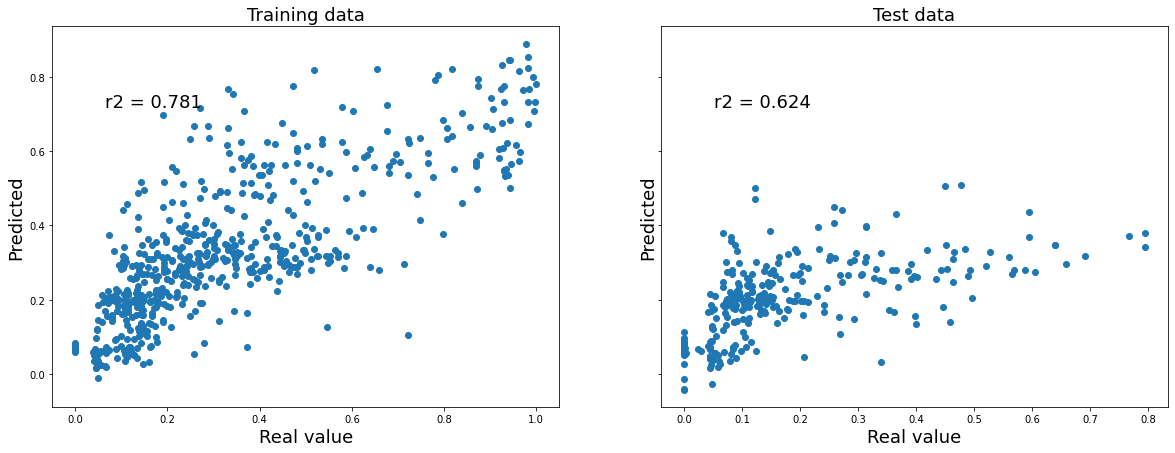

In [629]:
train_test_real_predicted_scatter(y_train, y_test, y_pred_train, y_pred_test)

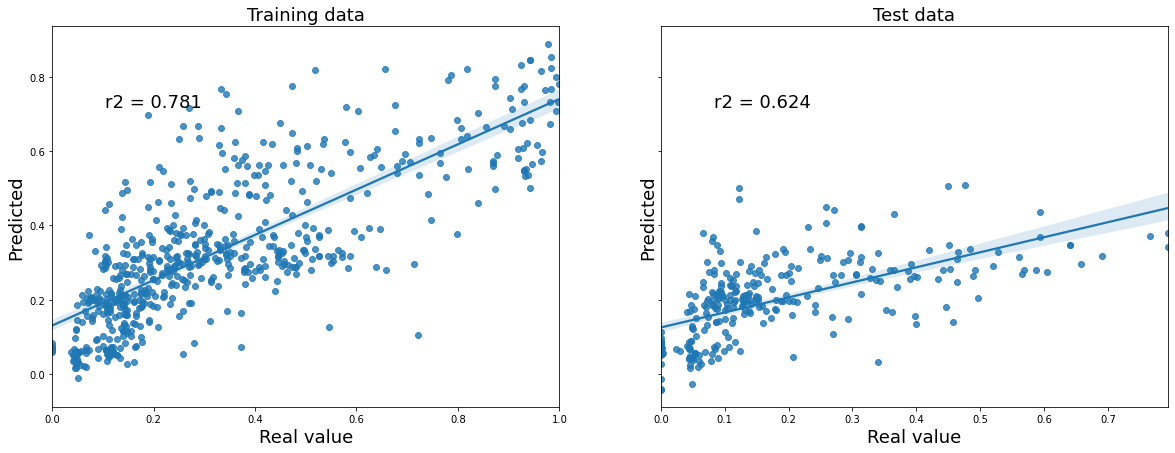

In [630]:
train_test_real_predicted_scatter_sns(y_train, y_test, y_pred_train, y_pred_test)

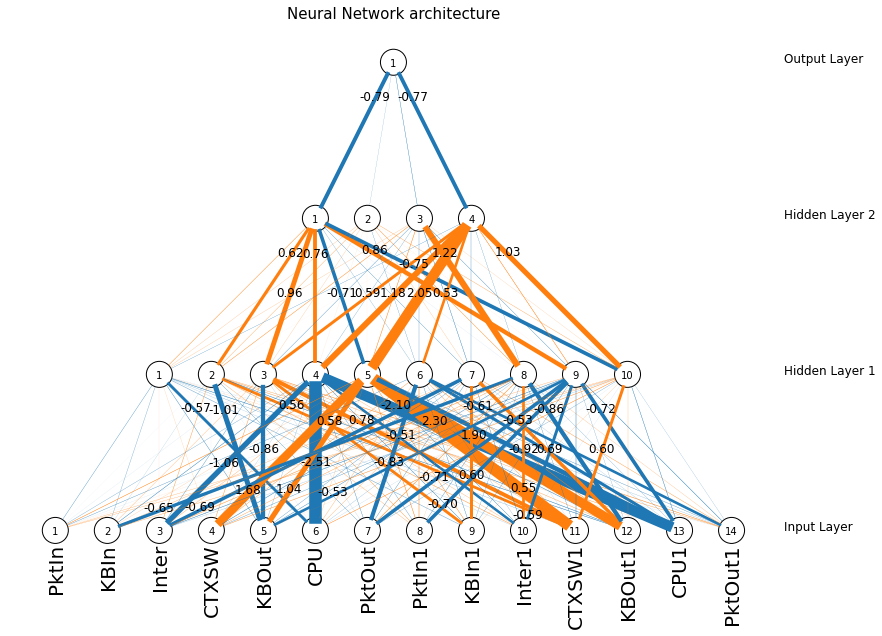

In [631]:
# Define the structure of the network
network_structure = np.hstack(([len(columns)], np.asarray(mlp.hidden_layer_sizes), [1]))

# Draw the Neural Network with weights
network=DrawNN(network_structure, mlp.coefs_, columns)
# network=DrawNN([3,4,1])
network.draw()

In [632]:
errors = []
cummulative_errors = []
y_predicted = np.zeros(len(X))
y_real = np.zeros(len(X))
cummulative_error = 0
start = 100
stop = 880
for i in range(start, stop):

  min_max_scaler = preprocessing.MinMaxScaler()
  X_scaled = min_max_scaler.fit_transform(X)
  y_scaled = min_max_scaler.fit_transform(y.values.reshape(-1, 1))

  X_train = X_scaled[0:i,:]
  y_train = y_scaled[0:i,:]
  X_test  = X_scaled[i:i+1,:]
  y_test  = y_scaled[i:i+1,:]

  mlp.fit(X_train, y_train)

  y_pred_train = mlp.predict(X_train)
  y_pred_test  = mlp.predict(X_test)

  r2_train = np.corrcoef(y_train.ravel(), y_pred_train)[0,1]
  r2_test  = np.corrcoef(y_test.ravel(), y_pred_test)[0,1]

  error = y_test[0]-y_pred_test[0]
  abs_error = abs(error)
  errors.append(abs_error)
  cummulative_error = cummulative_error + abs_error
  # print(cummulative_error)
  cummulative_errors.append(cummulative_error)
  y_predicted[i+1] = y_pred_test[0]
  y_real[i+1] = y_test[0]

  if( i % 50 == 0 ):
    print('step = ', i, '\t', 'r2 = ', np.corrcoef(y_real, y_predicted)[0,1])


step =  100 	 r2 =  0.9999999999999921
step =  150 	 r2 =  0.9016387568118763
step =  200 	 r2 =  0.9166711774105217
step =  250 	 r2 =  0.9112218204485937
step =  300 	 r2 =  0.8756763532441965
step =  350 	 r2 =  0.8561826275850327
step =  400 	 r2 =  0.8528644229201526
step =  450 	 r2 =  0.8333540341336645
step =  500 	 r2 =  0.8187074054263621
step =  550 	 r2 =  0.8071966135554854
step =  600 	 r2 =  0.7975202677699986
step =  650 	 r2 =  0.7893884936814329
step =  700 	 r2 =  0.7785605224904616
step =  750 	 r2 =  0.7608754691989904
step =  800 	 r2 =  0.7329734181291745
step =  850 	 r2 =  0.7185991150002737


[101.8341535]


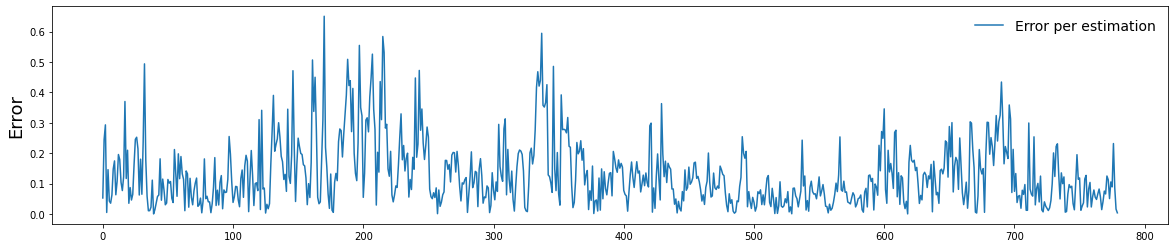

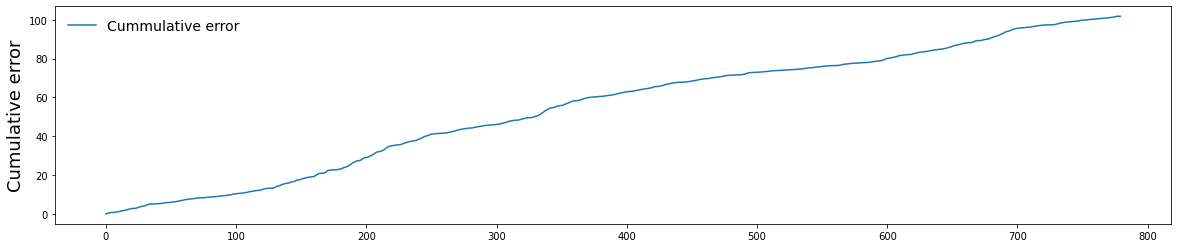

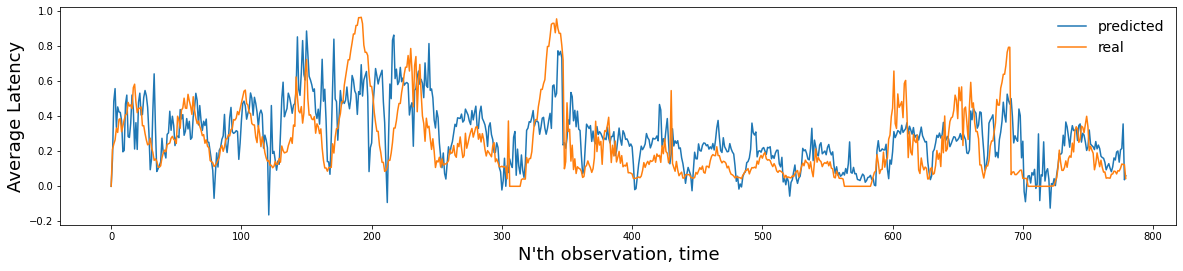

In [633]:
print(cummulative_error)

cummulative_plots(errors, cummulative_errors, y_real[100:880], y_predicted[100:880])

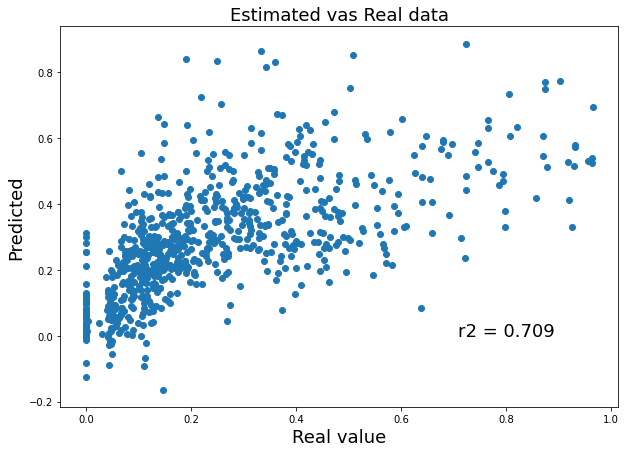

In [634]:
cummaulative_real_predicted_scatter(y_real, y_predicted)

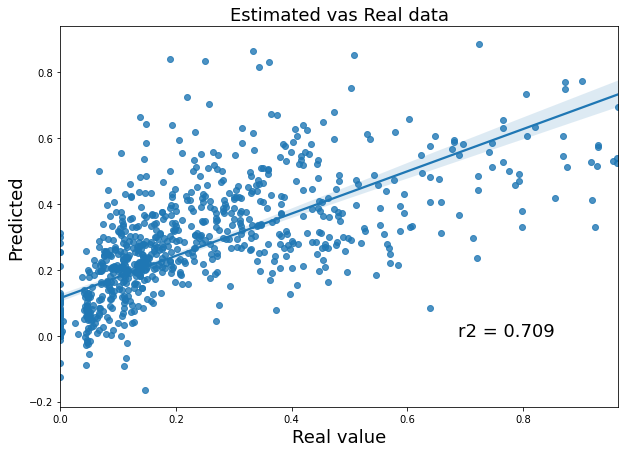

In [635]:
cummaulative_real_predicted_scatter_sns(y_real, y_predicted)

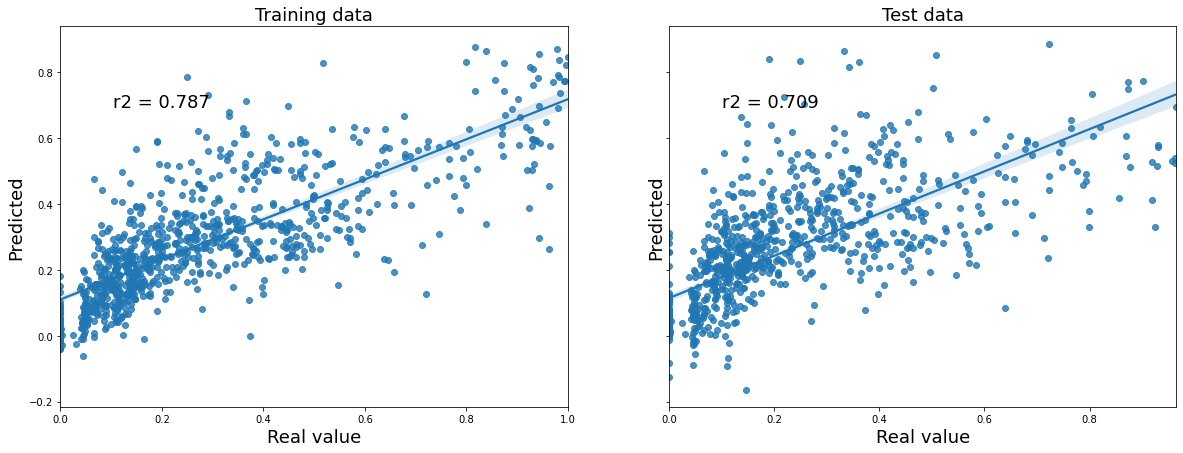

In [636]:
train_test_real_predicted_scatter_sns(y_train, y_real, y_pred_train, y_predicted)

# Playgroud end

# Keras implementation

Ugyan ez csak egy másik keretrendszerrel

In [92]:
from keras.models import Sequential
from keras.layers import Dense

In [376]:
# pre processing

min_max_scaler = preprocessing.MinMaxScaler()
X_scaled = min_max_scaler.fit_transform(X)
y_scaled = min_max_scaler.fit_transform(y.values.reshape(-1, 1))

i = 600
X_train = X_scaled[0:i,:]
y_train = y_scaled[0:i,:]
X_test  = X_scaled[i:,:]
y_test  = y_scaled[i:,:]

# set input dim
input_dim = X.shape[1]

# create model
model = Sequential()
model.add(Dense(10, input_dim=input_dim, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile model
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])

# Fit the model
# history = model.fit(X_train, y_train, epochs=150, batch_size=10, verbose=0)
history = model.fit(X_train, y_train, epochs=150, batch_size=10, verbose=0, validation_split=0.2)

# Evaluate scores
r2_train = np.corrcoef(y_train.ravel(), y_pred_train.ravel())[0,1]
r2_test  = np.corrcoef(y_test.ravel(), y_pred_test.ravel())[0,1]

print('r2 train = ', r2_train)
print('r2 test  = ', r2_test)

# Predict the values
y_pred_train = model.predict(X_train)
y_pred_test  = model.predict(X_test)

r2 train =  0.7089055860590678
r2 test  =  0.5445830184005073


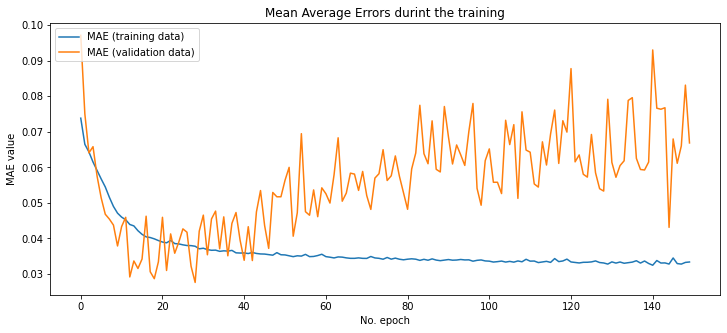

In [369]:
# Plot history
plt.figure(figsize=(12, 5))
plt.plot(history.history['loss'], label='MAE (training data)')
plt.plot(history.history['val_loss'], label='MAE (validation data)')
plt.title('Mean Average Errors durint the training')
plt.ylabel('MAE value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

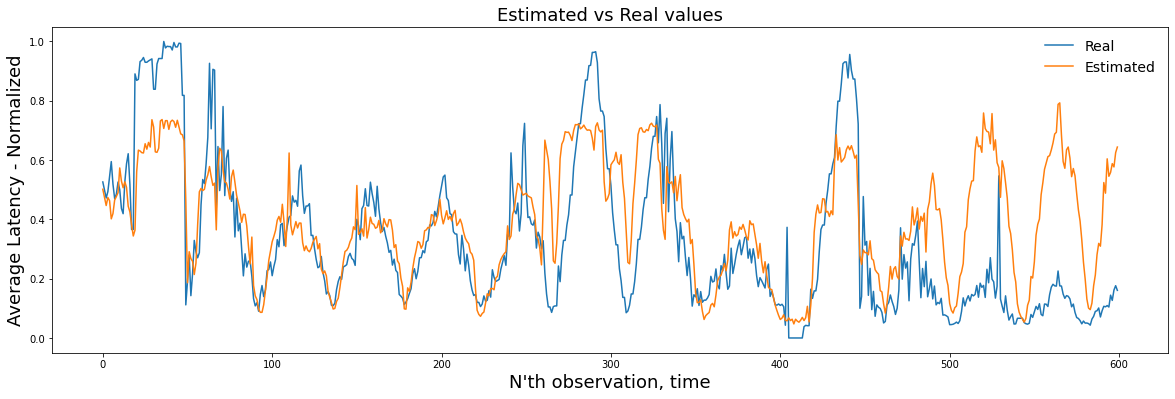

In [390]:
timeline_plot(y_train, y_pred_train)

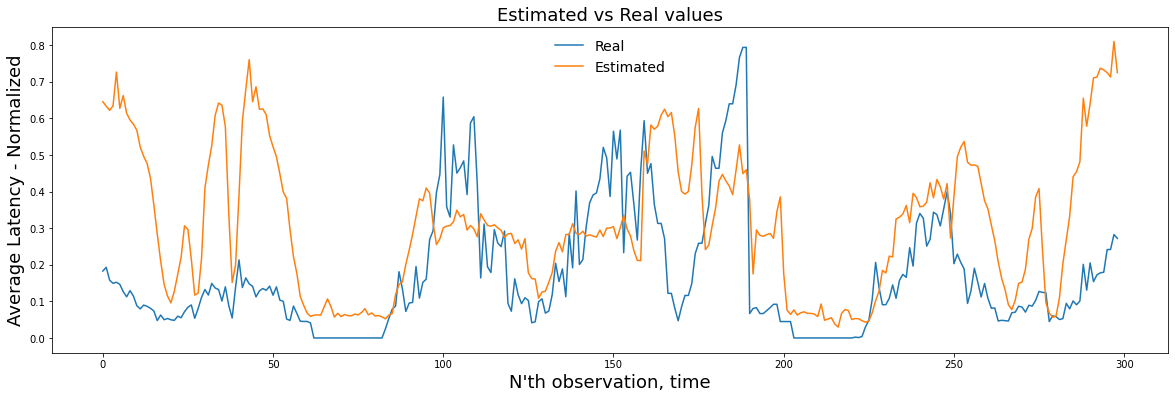

In [391]:
timeline_plot(y_test, y_pred_test)

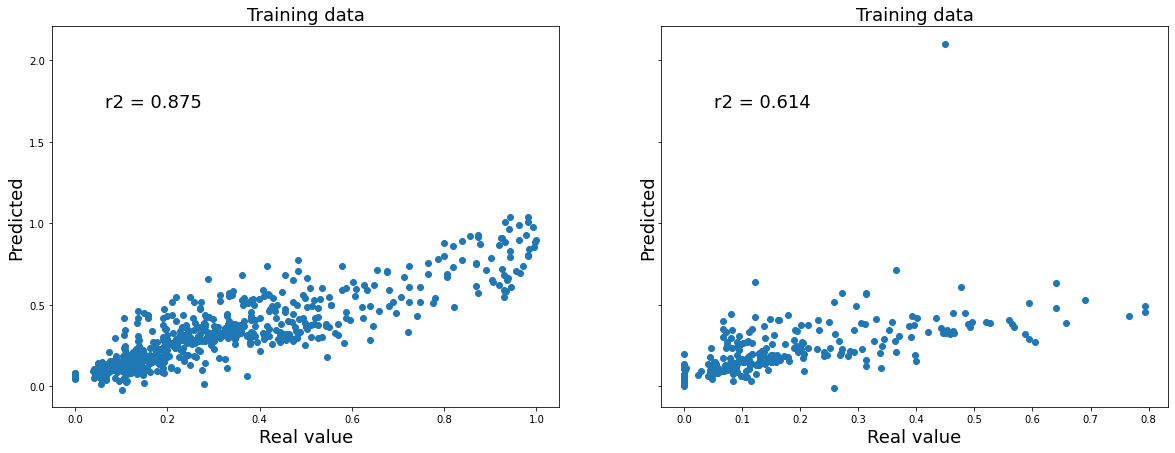

In [417]:
train_test_real_predicted_scatter(y_train, y_test, y_pred_train, y_pred_test)

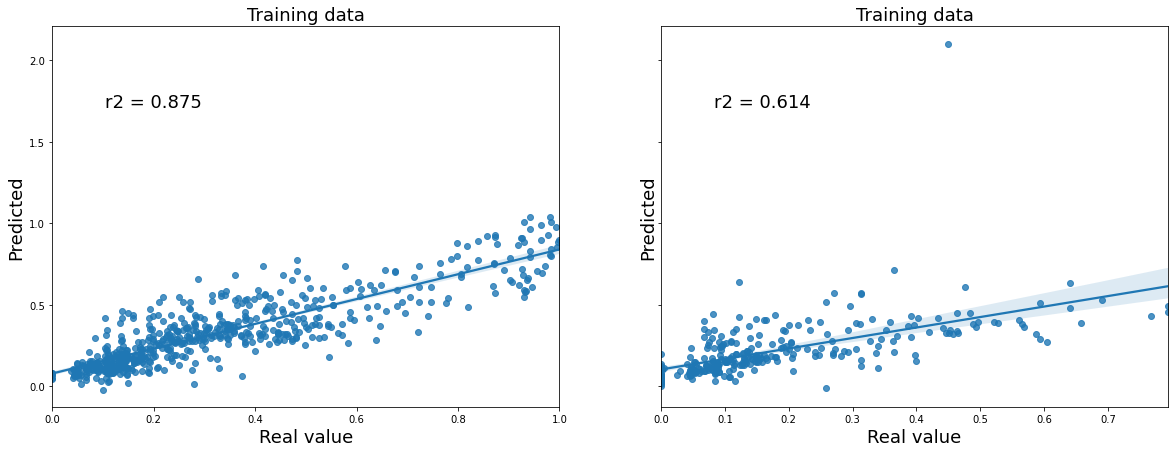

In [424]:
train_test_real_predicted_scatter_sns(y_train, y_test, y_pred_train, y_pred_test)